In [1]:
library(Seurat)
library(SeuratWrappers)
library(harmony)
library(SeuratDisk)
library(dplyr)
library(ggplot2)
library(tidyr)
library(scales)

Attaching SeuratObject

Le chargement a nécessité le package : Rcpp

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat


Attachement du package : ‘dplyr’


Les objets suivants sont masqués depuis ‘package:stats’:

    filter, lag


Les objets suivants sont masqués depuis ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
options(repr.plot.width=20, repr.plot.height=20) # To set the figure size in Jupyter

In [3]:
embryos <- readRDS("/home/adufour/work/rds_storage/all_cells/all_embryos.rds")

In [4]:
embryos <- NormalizeData(embryos) %>% FindVariableFeatures() %>% ScaleData() %>% RunPCA(verbose = FALSE)
embryos.integrated <- RunHarmony(embryos, group.by.vars = "SAMP")

Centering and scaling data matrix

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


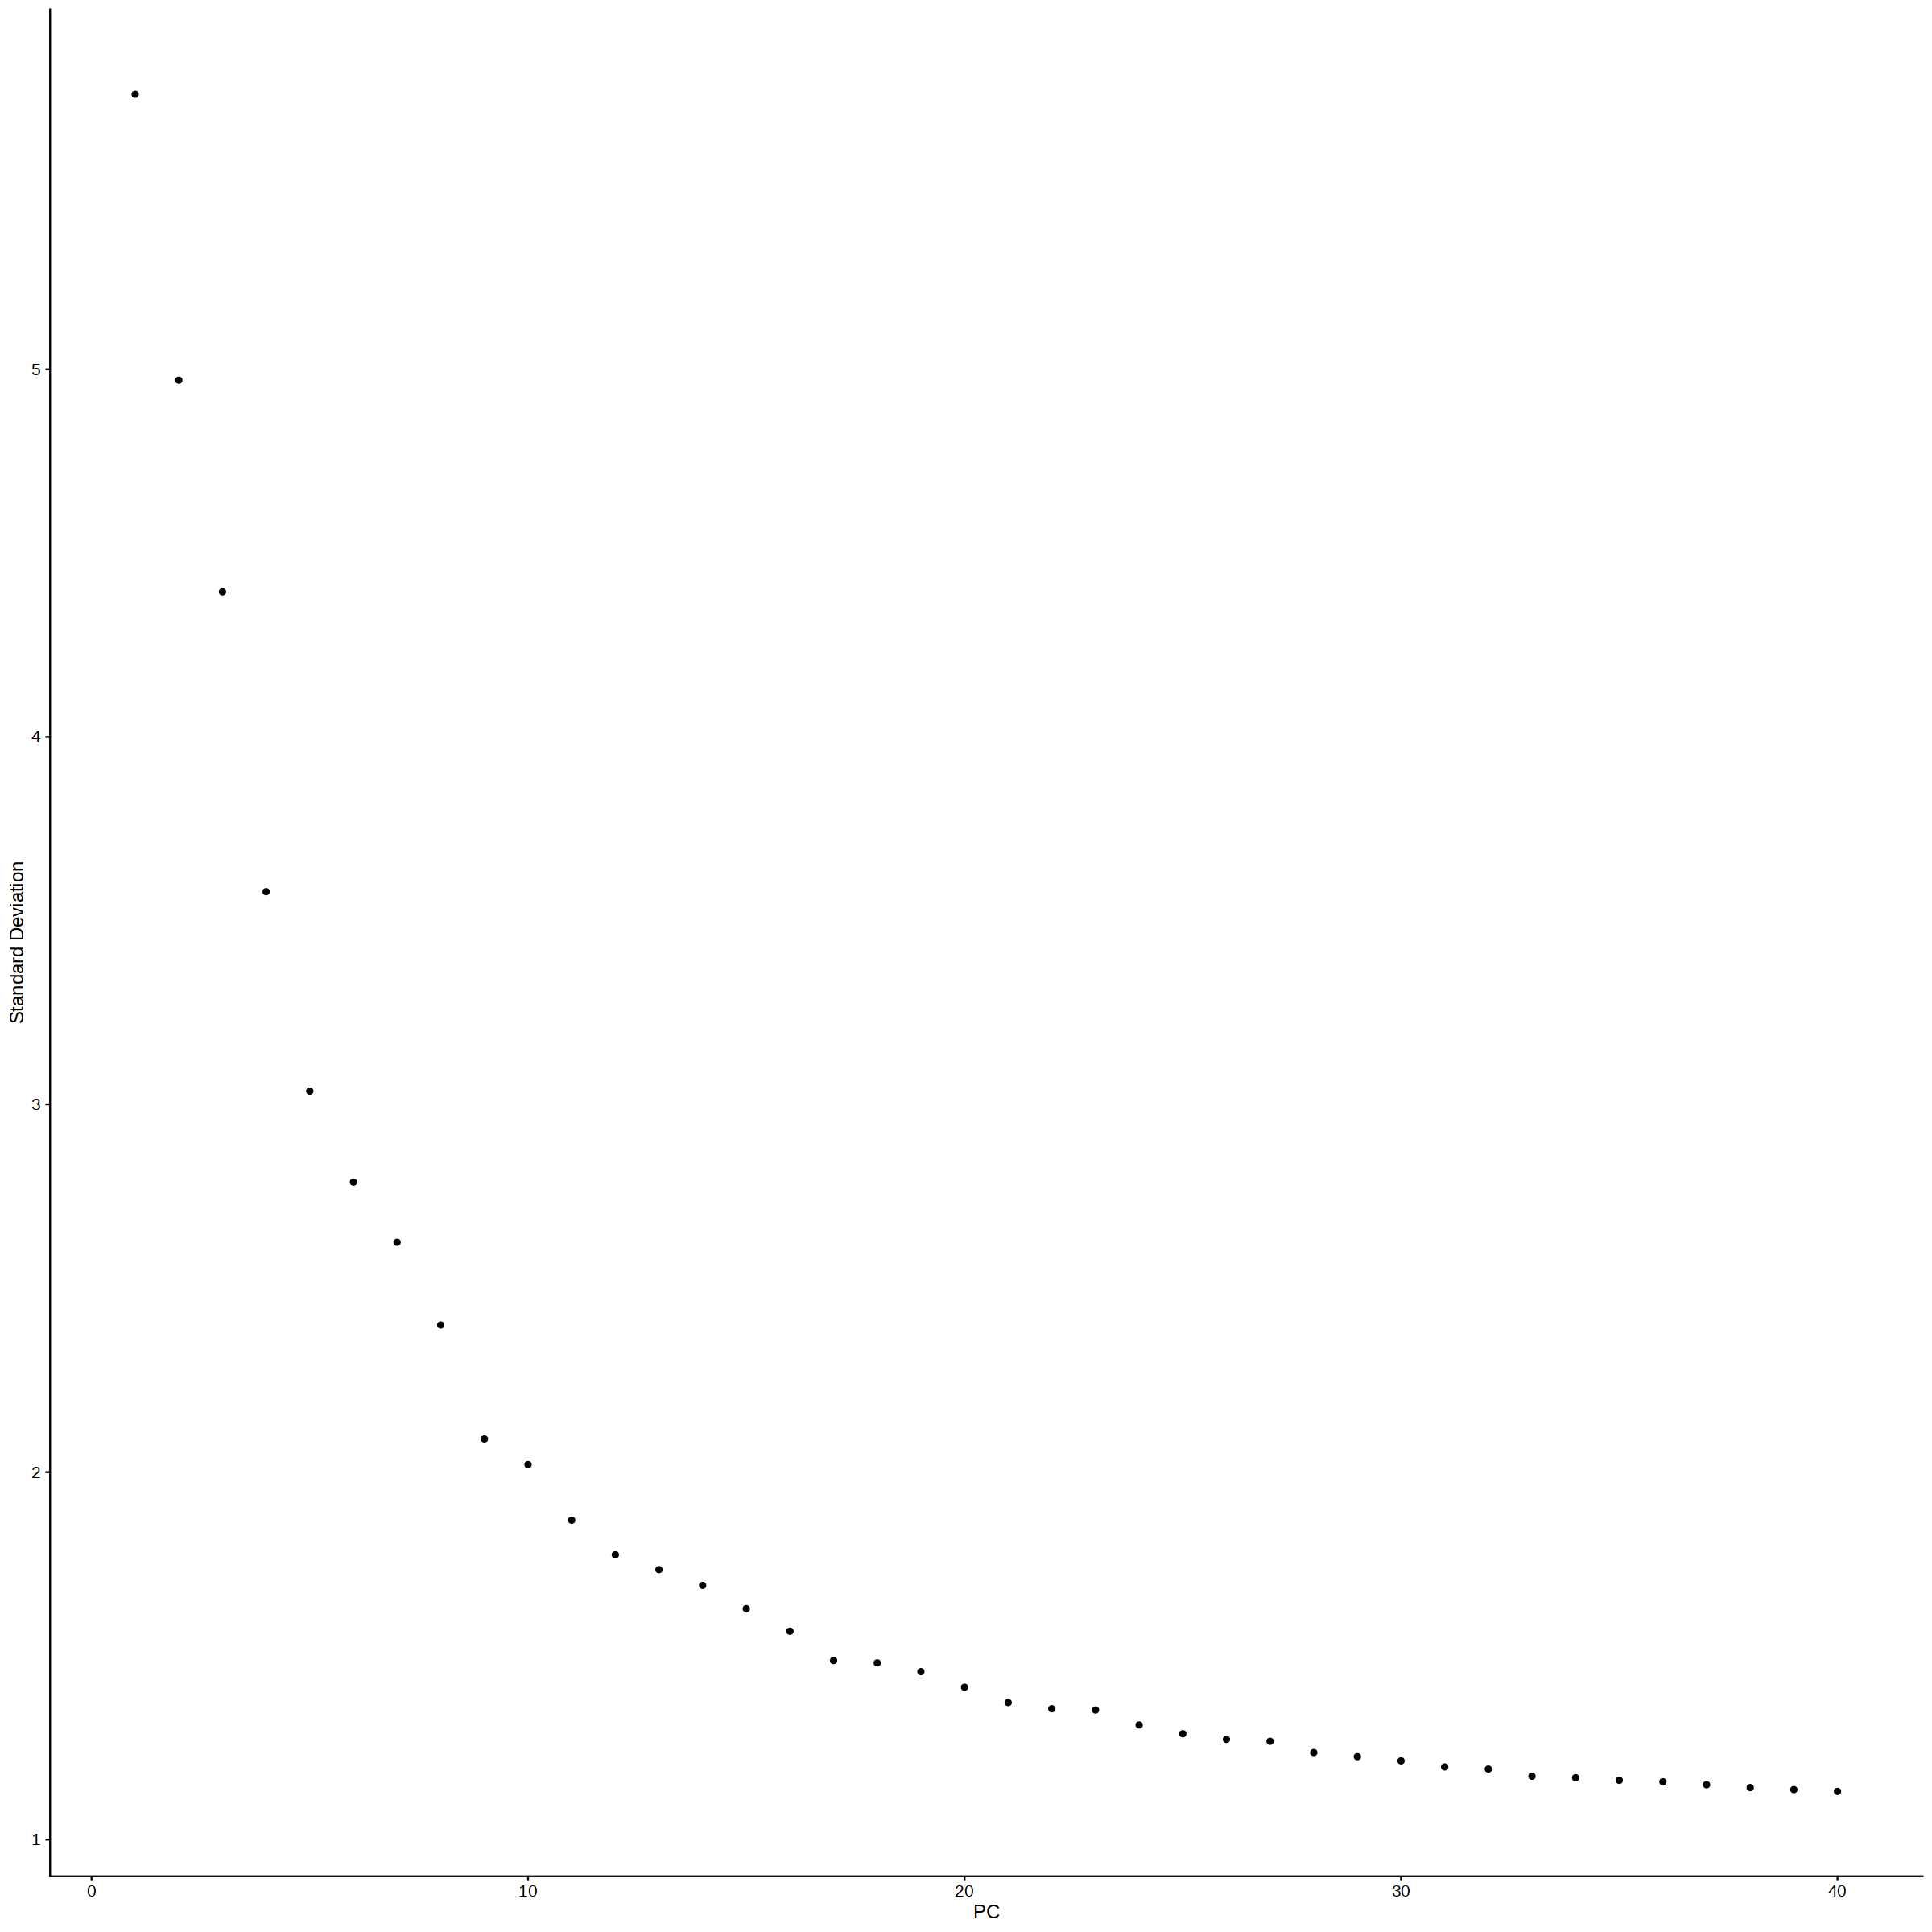

In [5]:
ElbowPlot(embryos.integrated, ndims = 40)

In [6]:
embryos.integrated <- RunUMAP(embryos.integrated, dims = 1:30)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
10:28:59 UMAP embedding parameters a = 0.9922 b = 1.112

10:28:59 Read 34888 rows and found 30 numeric columns

10:28:59 Using Annoy for neighbor search, n_neighbors = 30

10:28:59 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:29:04 Writing NN index file to temp file /tmp/RtmpdI2Kpw/file22f92243ca12

10:29:04 Searching Annoy index using 1 thread, search_k = 3000

10:29:15 Annoy recall = 100%

10:29:16 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors 

In [7]:
embryos.integrated <- FindNeighbors(embryos.integrated, reduction = "harmony", dims = 1:30)

Computing nearest neighbor graph

Computing SNN



In [8]:
embryos.integrated <- FindClusters(embryos.integrated, resolution = 0.05)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 34888
Number of edges: 1206604

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9773
Number of communities: 6
Elapsed time: 9 seconds


In [9]:
Idents(embryos.integrated) <- "cell_type"

In [11]:
embryos.integrated$cell_type_time <- paste(embryos.integrated@meta.data$cell_type, embryos.integrated@meta.data$TIME, sep = "_")

In [12]:
embryos.integrated@meta.data$cell_type[embryos.integrated@meta.data$cell_type == "Hypoblast"] <- "HYPO"
embryos.integrated@meta.data$cell_type[embryos.integrated@meta.data$cell_type == "Trophectoderm"] <- "TE"
embryos.integrated@meta.data$cell_type[embryos.integrated@meta.data$cell_type == "Epiblast"] <- "EPI"
embryos.integrated@meta.data$cell_type[embryos.integrated@meta.data$cell_type == "Mesendoderm"] <- "MES"

In [13]:
custom_colors <- list()

colors_dutch <- c(
  '#FFC312','#C4E538','#12CBC4','#FDA7DF','#ED4C67',
  '#F79F1F','#A3CB38','#1289A7','#D980FA','#B53471',
  '#EE5A24','#009432','#0652DD','#9980FA','#833471',
  '#EA2027','#006266','#1B1464','#5758BB','#6F1E51'
)

colors_spanish <- c(
  '#40407a','#706fd3','#f7f1e3','#34ace0','#33d9b2',
  '#2c2c54','#474787','#aaa69d','#227093','#218c74',
  '#ff5252','#ff793f','#d1ccc0','#ffb142','#ffda79',
  '#b33939','#cd6133','#84817a','#cc8e35','#ccae62'
)

custom_colors$discrete <- c(colors_dutch, colors_spanish)

custom_colors$cell_cycle <- setNames(
  c('#45aaf2', '#f1c40f', '#e74c3c', '#7f8c8d'),
  c('G1',      'S',       'G2M',     '-')
)

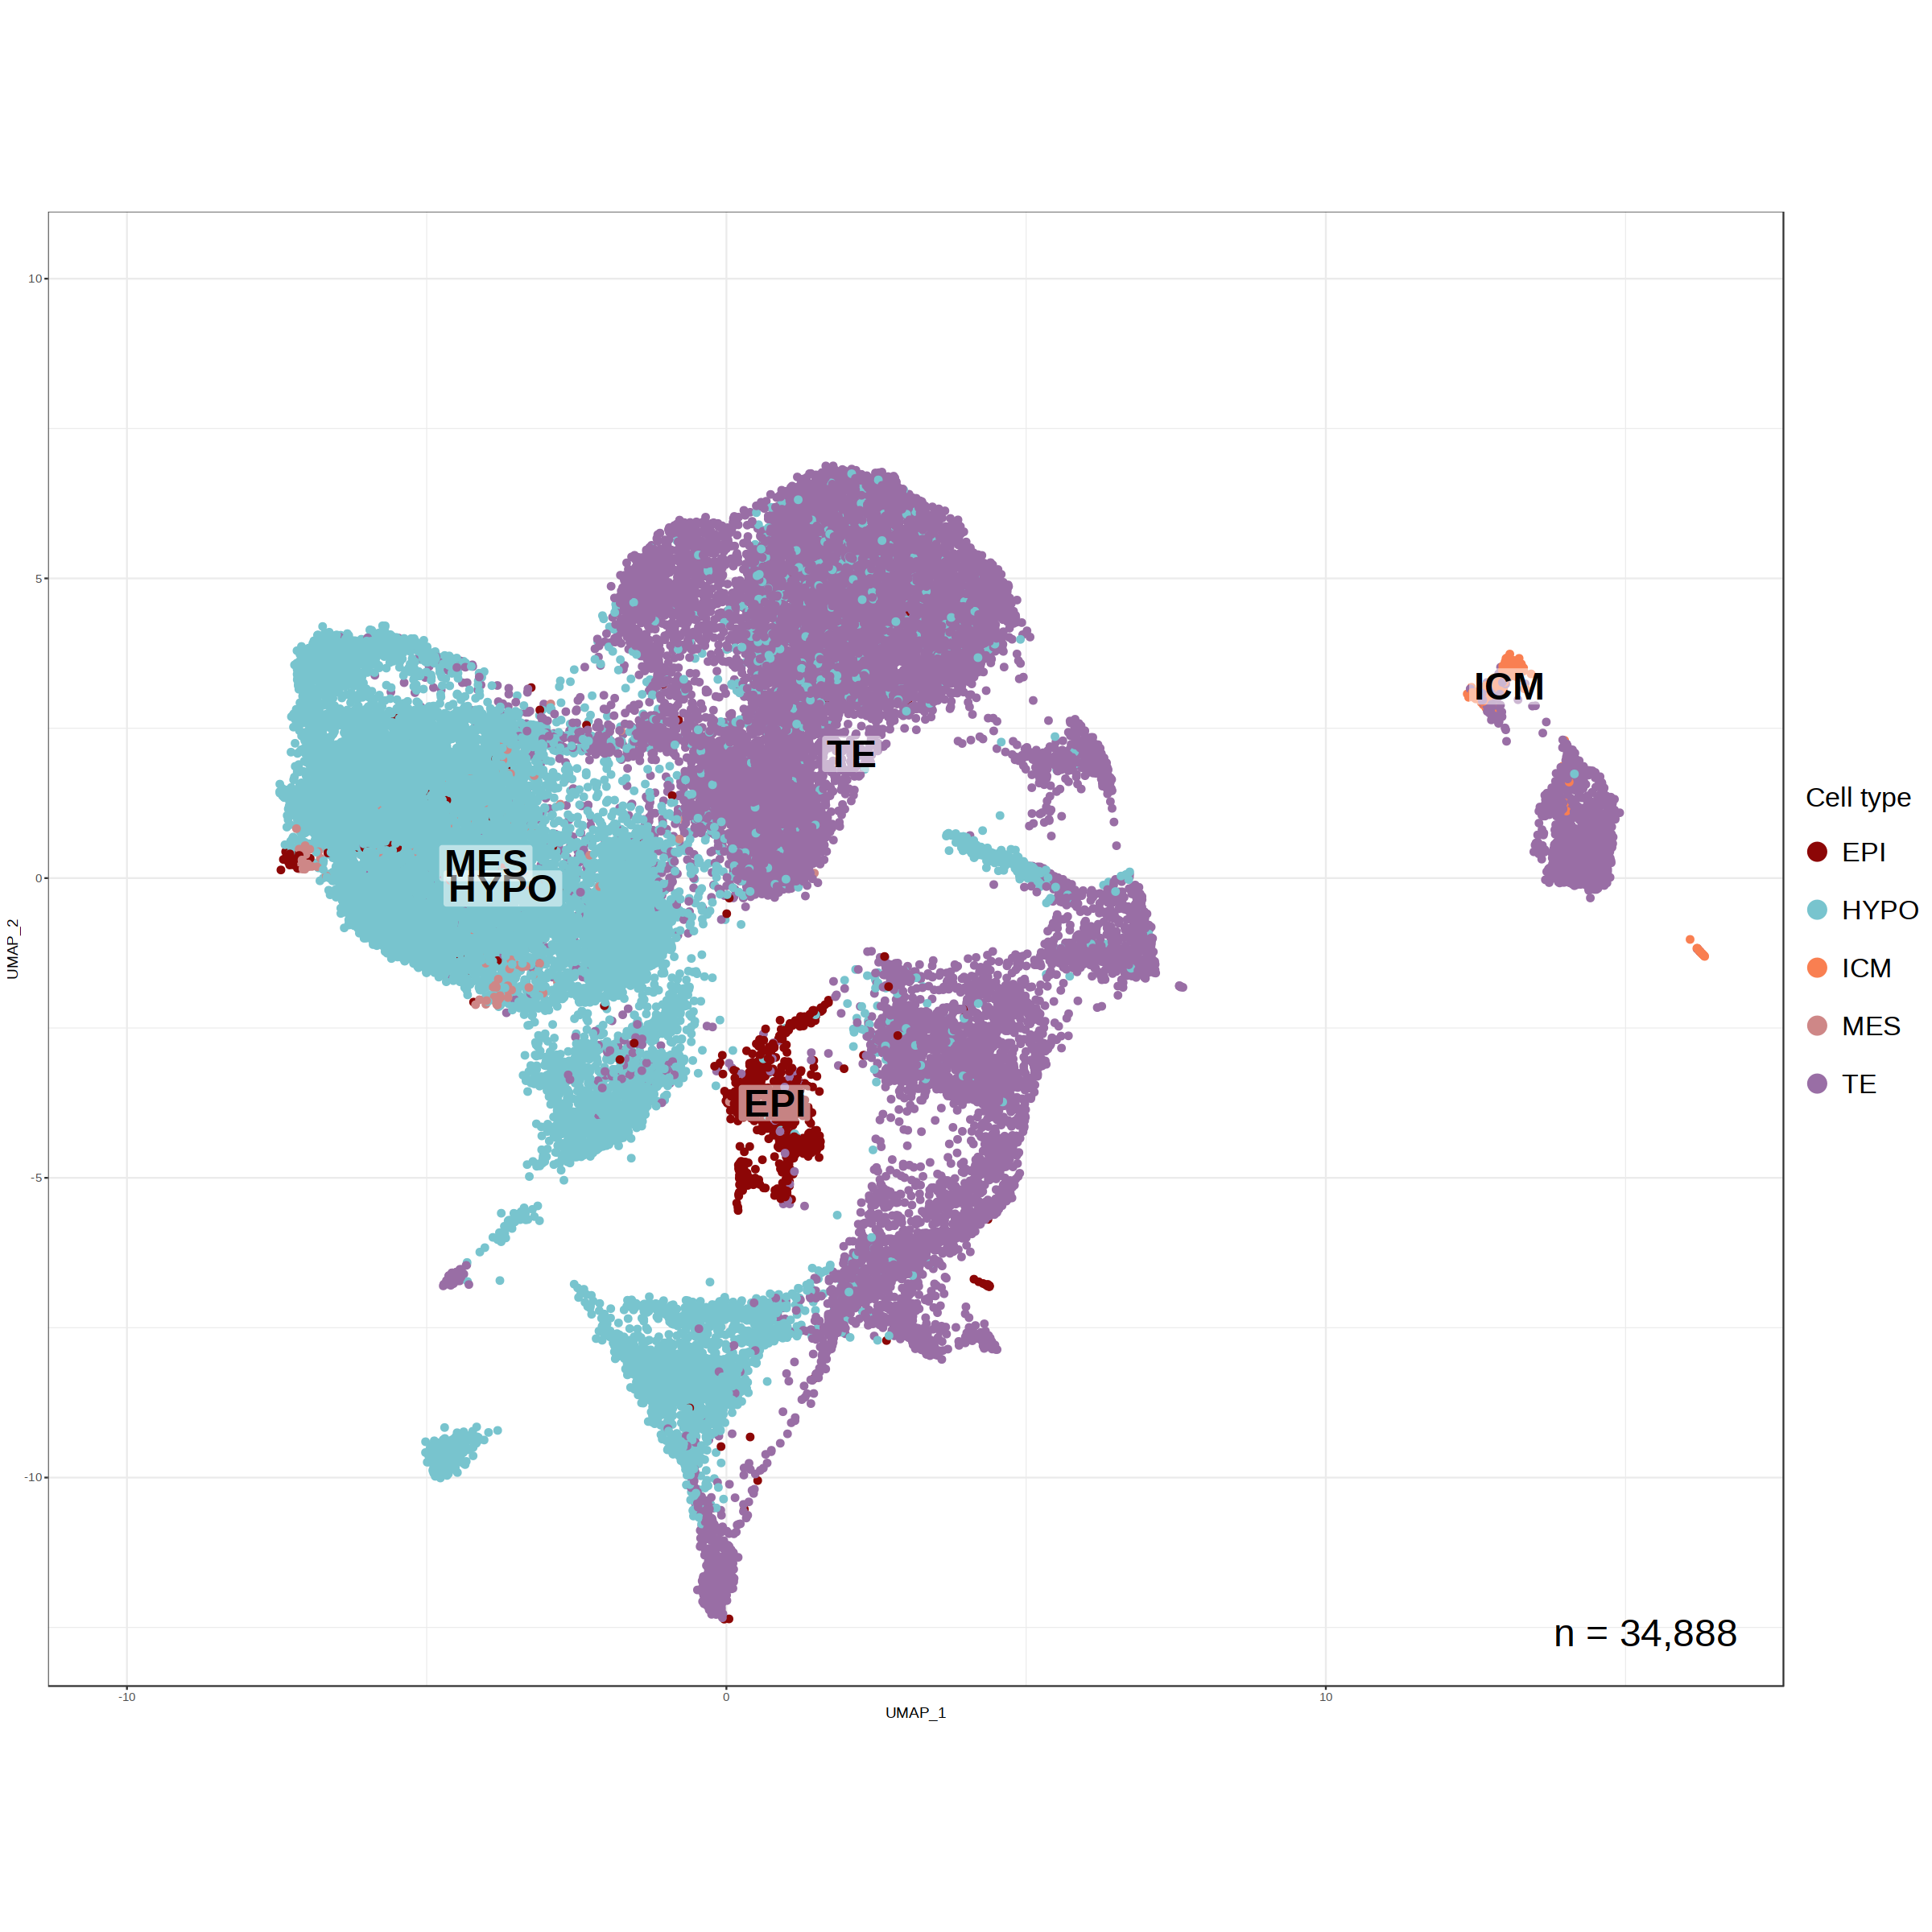

In [14]:
UMAP_centers_cell_type <- tibble(
    UMAP_1 = as.data.frame(embryos.integrated@reductions$umap@cell.embeddings)$UMAP_1,
    UMAP_2 = as.data.frame(embryos.integrated@reductions$umap@cell.embeddings)$UMAP_2,
    cell_type = embryos.integrated@meta.data$cell_type
  ) %>%
  group_by(cell_type) %>%
  summarize(x = median(UMAP_1), y = median(UMAP_2))

plot <- bind_cols(embryos.integrated@meta.data, as.data.frame(embryos.integrated@reductions$umap@cell.embeddings)) %>%
  ggplot(aes(UMAP_1, UMAP_2, color = cell_type)) +
  geom_point(size = 2) +
  geom_label(
    data = UMAP_centers_cell_type,
    mapping = aes(x, y, label = cell_type),
    size = 10,
    fill = 'white',
    color = 'black',
    fontface = 'bold',
    alpha = 0.5,
    label.size = 0,
    show.legend = FALSE
  ) +
  theme_bw() +
  expand_limits(x = c(-10,10.5), y = c(-10,10)) +
  scale_color_manual(values = c("#8c0606", "#78c4ce", "#f97f51", "#ce8787", "#996ea5")) +
  labs(color = 'Cell type') +
  guides(colour = guide_legend(override.aes = list(size = 6))) +
  theme(
      legend.position = 'right',
      legend.title = element_text(size = 20),
      legend.text = element_text(size = 20),
      legend.key.height = unit(3,"line")
  ) +
  coord_fixed() +
  annotate(
    geom = 'text', 
    x = Inf, 
    y = -Inf,
    label = paste0('n = ', format(nrow(embryos.integrated@meta.data), big.mark = ',', trim = TRUE)),
    vjust = -1.5,
    hjust = 1.25,
    color = 'black',
    size = 10
  )

plot

In [17]:
ggsave(
  '/home/adufour/work/notebook/plots/ALL_UMAP/ALL_UMAP_by_cell_type.svg',
  plot,
  height = 18,
  width = 20
)

In [18]:
embryos.integrated$order <- factor(embryos.integrated$TIME, levels = c('E5', 'E7', 'E9', 'E11'), ordered = TRUE)

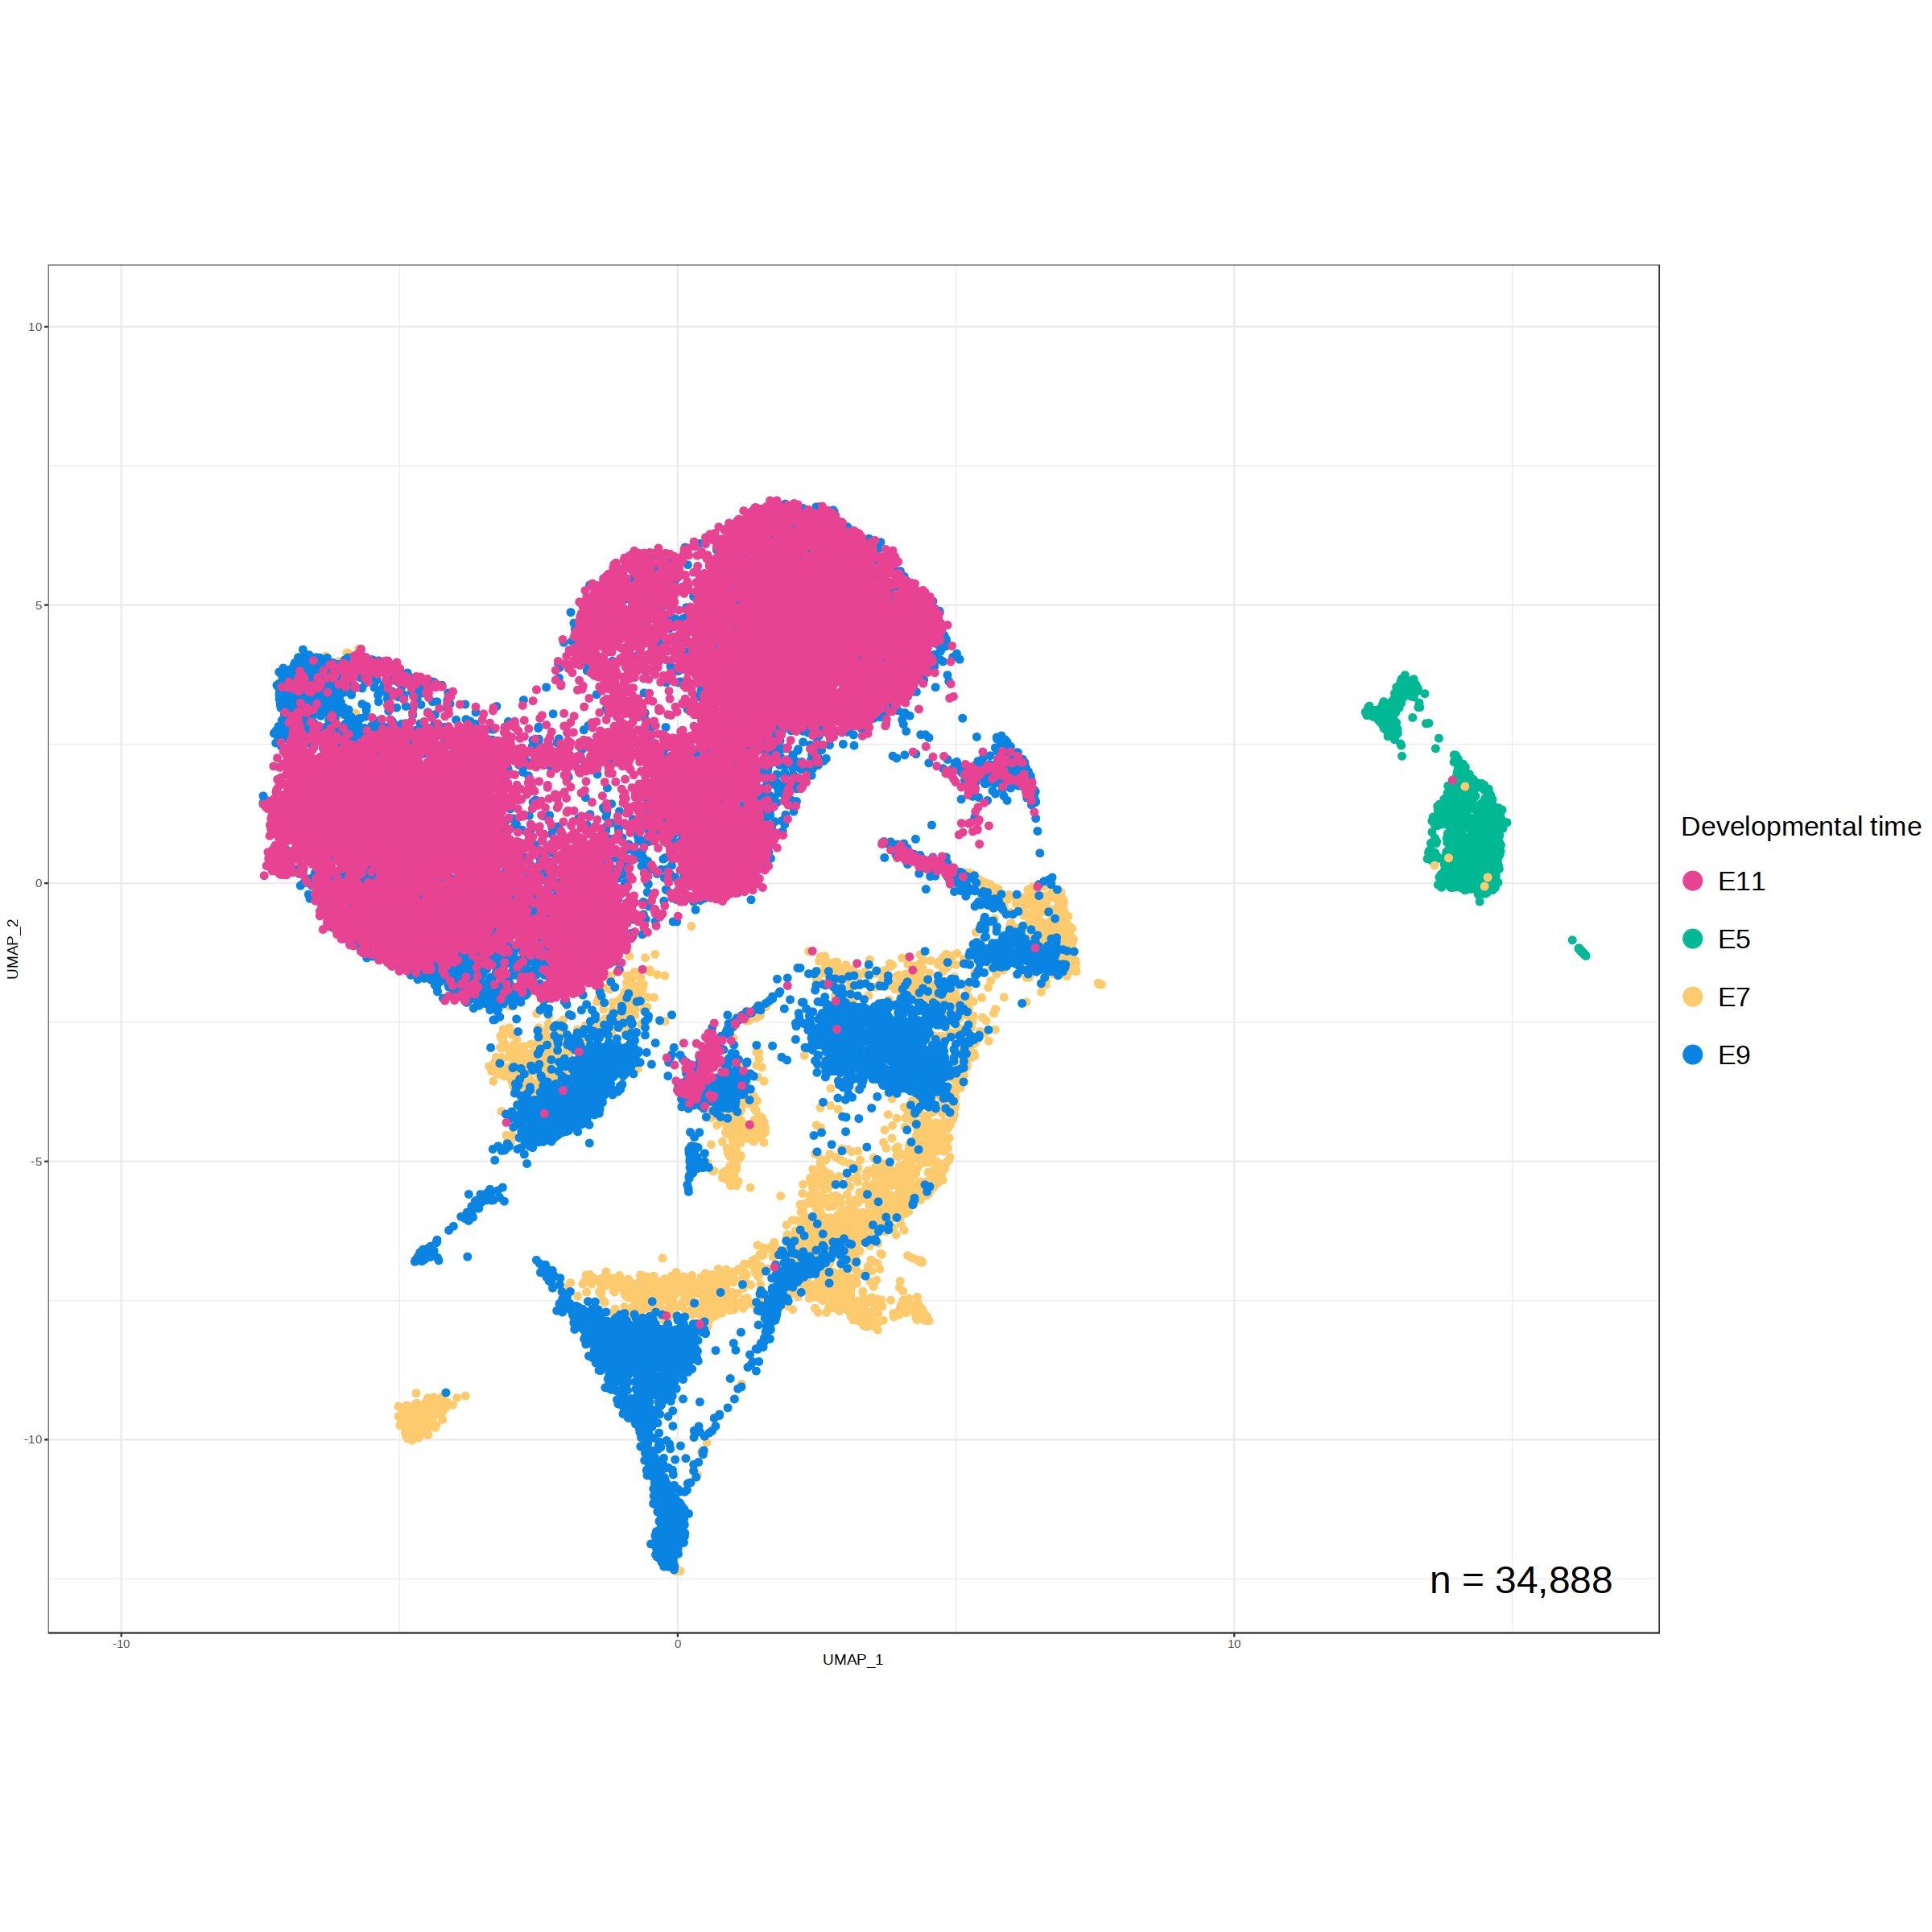

In [20]:
UMAP_centers_cell_type <- tibble(
    UMAP_1 = as.data.frame(embryos.integrated@reductions$umap@cell.embeddings)$UMAP_1,
    UMAP_2 = as.data.frame(embryos.integrated@reductions$umap@cell.embeddings)$UMAP_2,
    TIME = embryos.integrated@meta.data$TIME
  ) %>%
  group_by(TIME) %>%
  summarize(x = median(UMAP_1), y = median(UMAP_2))

plot <- bind_cols(embryos.integrated@meta.data, as.data.frame(embryos.integrated@reductions$umap@cell.embeddings)) %>%
  ggplot(aes(UMAP_1, UMAP_2, color = as.factor(TIME))) +
  geom_point(size = 2) +
  theme_bw() +
  expand_limits(x = c(-10,10.5), y = c(-10,10)) +
  scale_color_manual(values = c("#e84393", "#00b894", "#fdcb6e", "#0984e3")) +
  labs(color = 'Developmental time') +
  guides(colour = guide_legend(override.aes = list(size = 6))) +
  theme(legend.position = 'right',
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 20),
        legend.key.height=unit(3,"line")
       ) +
  coord_fixed() +
  annotate(
    geom = 'text',
    x = Inf,
    y = -Inf,
    label = paste0('n = ', format(nrow(embryos.integrated@meta.data), big.mark = ',', trim = TRUE)),
    vjust = -1.5,
    hjust = 1.25,
    color = 'black',
    size = 10
  )

plot

In [21]:
ggsave(
  '/home/adufour/work/notebook/plots/ALL_UMAP/ALL_UMAP_by_TIME.svg',
  plot,
  height = 18,
  width = 20
)

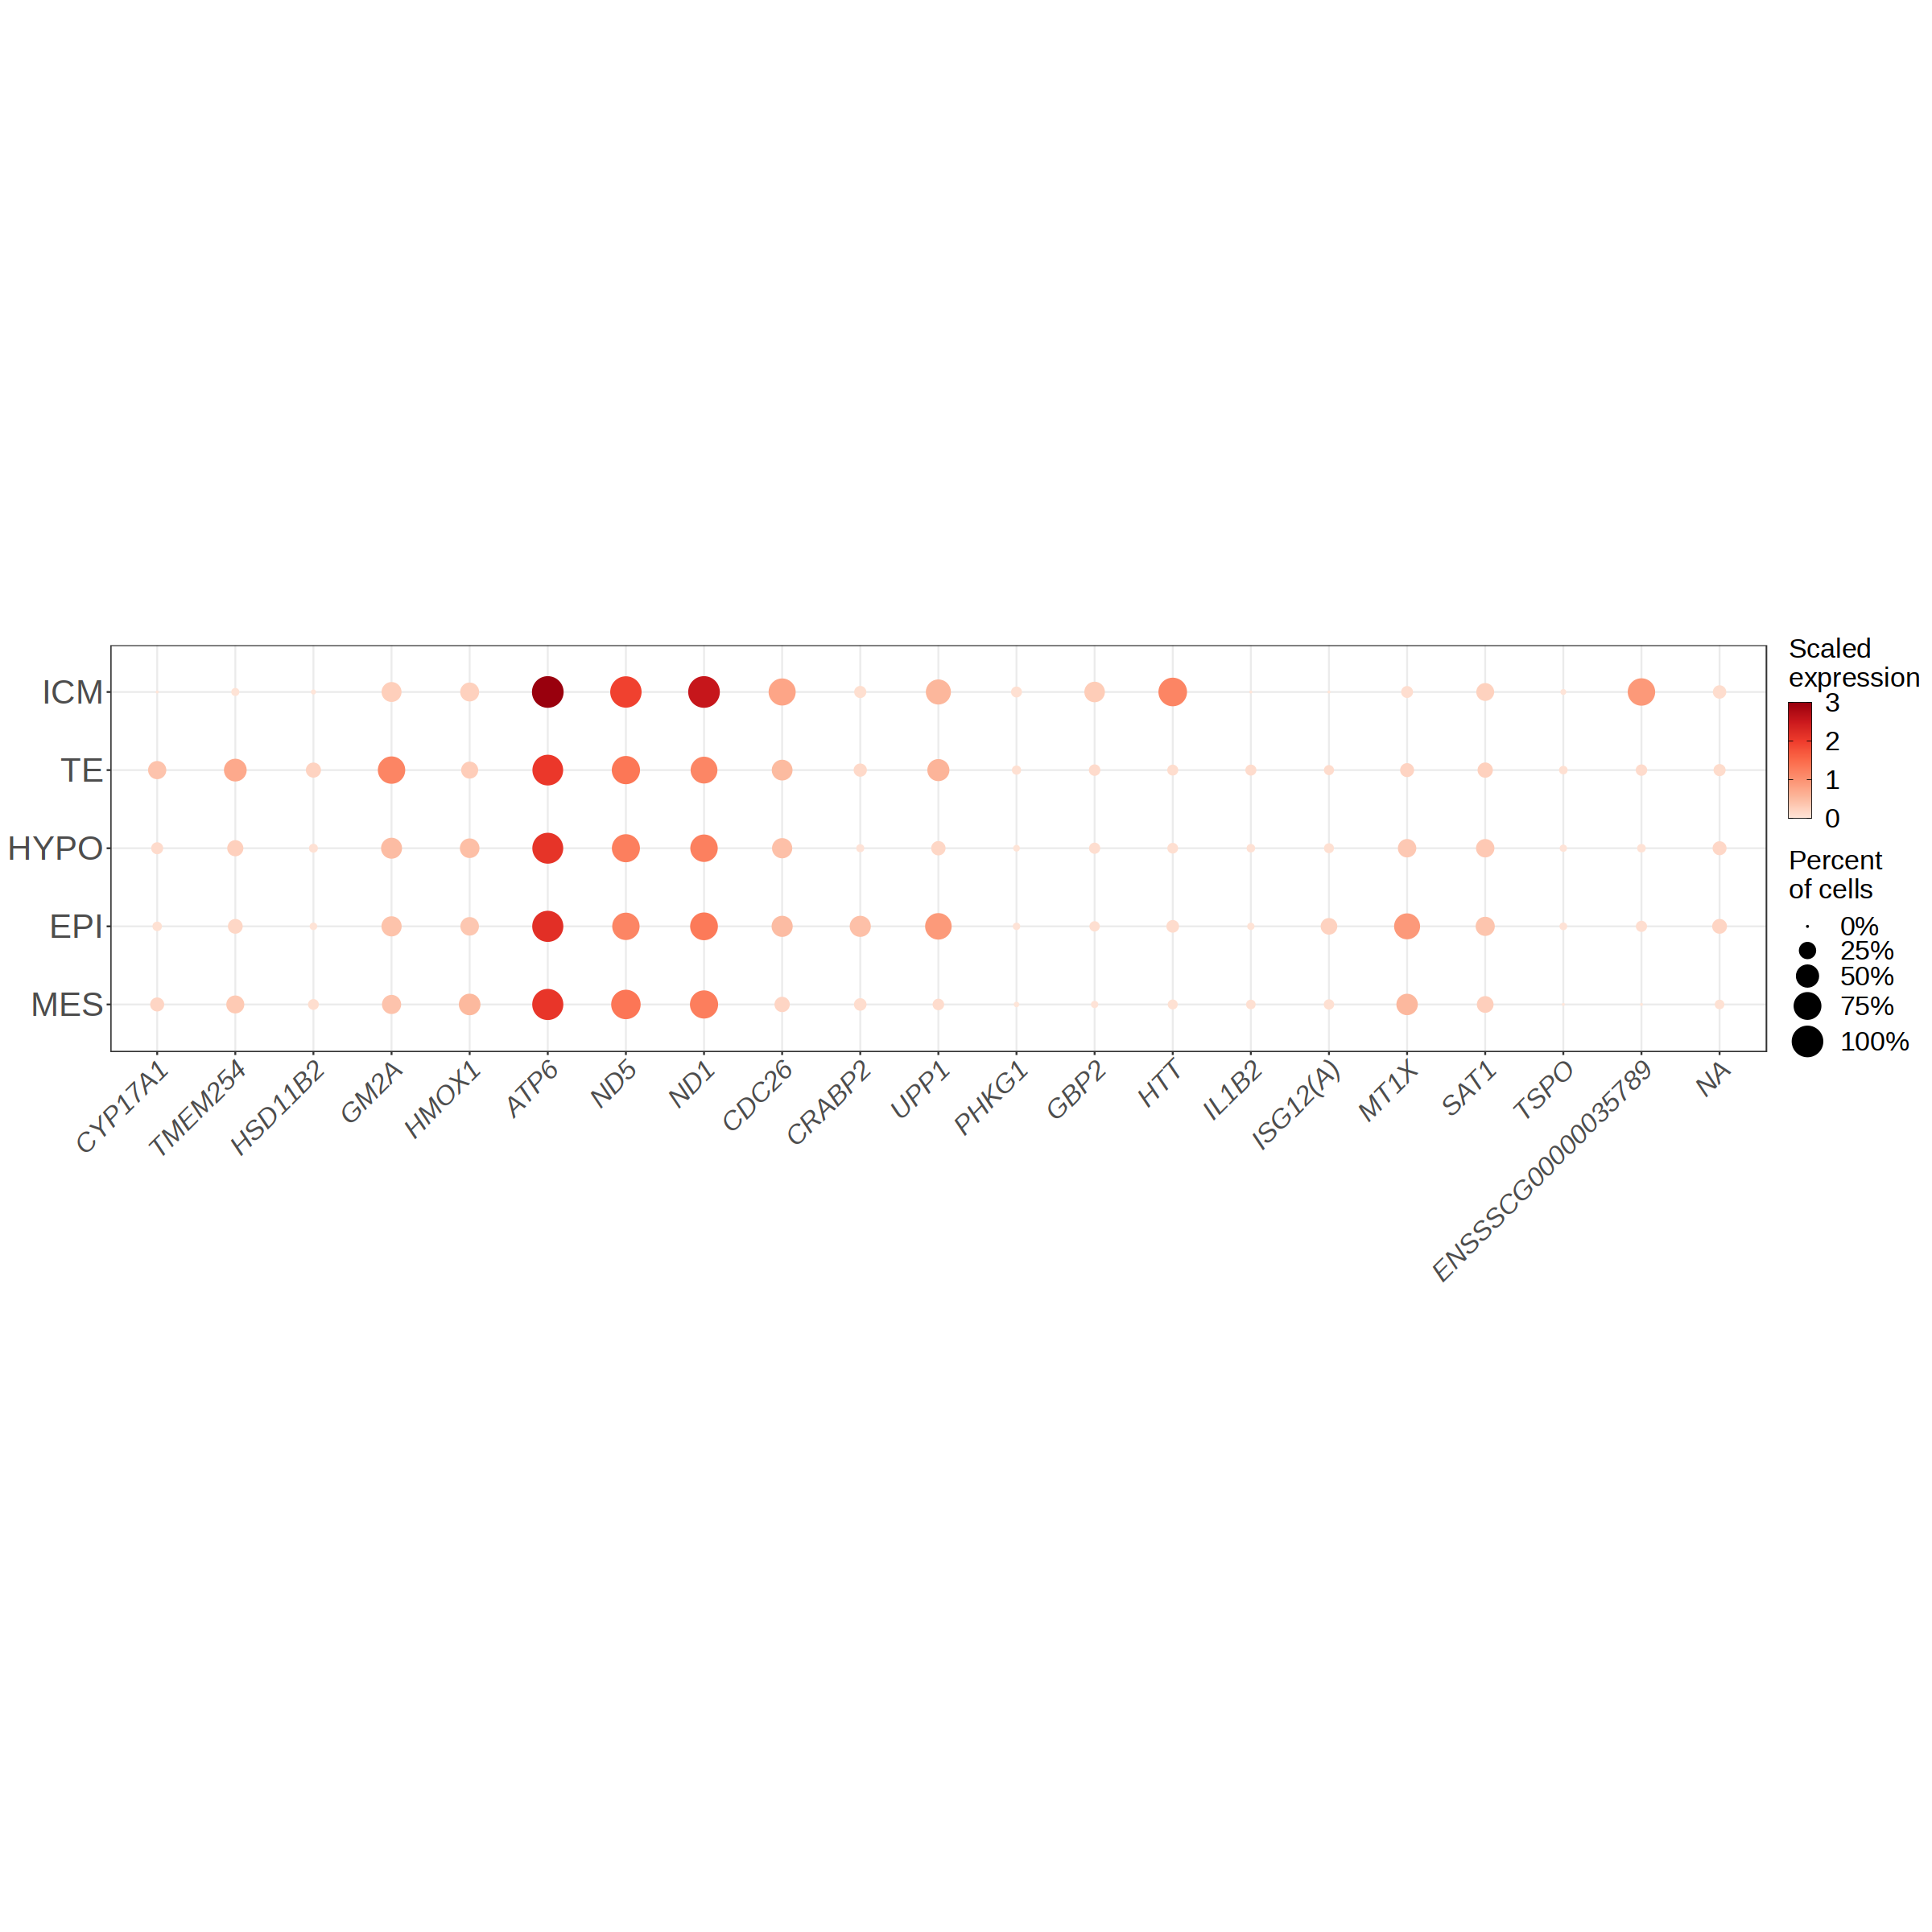

In [22]:
cluster_ids <- unique(embryos.integrated@meta.data$cell_type)

# select a set of genes for which we want to show expression
genes_to_show <- c("CYP17A1", "TMEM254", "HSD11B2", "GM2A", "HMOX1", "ATP6", "ND5", "ND1", "CDC26", "CRABP2", "UPP1", "PHKG1", "GBP2", "HTT", "IL1B2", 
                   "ENSSSCG00000008088", "ENSSSCG00000033667", "ENSSSCG00000039214", "ISG12(A)", "MT1X", "SAT1", "TSPO", "ENSSSCG00000001543", "ENSSSCG00000035789")

# for every cluster-gene combination, calculate the average expression across
# all cells and then transform the data into a data frame
expression_levels_per_cluster <- sapply(
    cluster_ids, function(x) {
      cells_in_current_cluster <- which(embryos.integrated@meta.data$cell_type == x)
      Matrix::rowMeans(embryos.integrated@assays$RNA@data[genes_to_show,cells_in_current_cluster])
    }
  ) %>%
  t() %>%
  rescale(to=c(0,3)) %>%
  as.data.frame() %>%
  mutate(cluster = rownames(.)) %>%
  dplyr::select(cluster, everything()) %>%
  pivot_longer(
    cols = c(2:ncol(.)),
    names_to = 'gene'
  ) %>%
  dplyr::rename(expression = value) %>%
  mutate(id_to_merge = paste0(cluster, '_', gene))

# for every cluster-gene combination, calculate the percentage of cells in the
# respective group that has at least 1 transcript (this means we consider it
# as expressing the gene) and then transform the data into a data frame
percentage_of_cells_expressing_gene <- sapply(
    cluster_ids, function(x) {
      cells_in_current_cluster <- which(embryos.integrated@meta.data$cell_type == x)
      Matrix::rowSums(embryos.integrated@assays$RNA@data[genes_to_show,cells_in_current_cluster] != 0)
    }
  ) %>%
  t() %>%
  as.data.frame() %>%
  mutate(cluster = rownames(.)) %>%
  dplyr::select(cluster, everything()) %>%
  pivot_longer(
    cols = c(2:ncol(.)),
    names_to = 'gene'
  ) %>%
  dplyr::rename(cell_count = value) %>%
  left_join(
    .,
    embryos.integrated@meta.data %>%
      group_by(cell_type) %>%
      tally() %>%
      dplyr::rename(cluster = cell_type),
    by = 'cluster') %>%
  mutate(
    id_to_merge = paste0(cluster, '_', gene),
    percent_cells = cell_count / n
  )

# merge the two data frames created before and plot the data
expression_levels_per_cluster[expression_levels_per_cluster$gene == 'ENSSSCG00000001543',]$gene <- "RPL10A"
percentage_of_cells_expressing_gene[percentage_of_cells_expressing_gene$gene == 'ENSSSCG00000001543',]$gene <- "RPL10A"
expression_levels_per_cluster[expression_levels_per_cluster$gene == 'ENSSSCG00000008088',]$gene <- "IL1B-1"
percentage_of_cells_expressing_gene[percentage_of_cells_expressing_gene$gene == 'ENSSSCG00000008088',]$gene <- "IL1B-1"
expression_levels_per_cluster[expression_levels_per_cluster$gene == 'ENSSSCG00000033667',]$gene <- "IL1B-2"
percentage_of_cells_expressing_gene[percentage_of_cells_expressing_gene$gene == 'ENSSSCG00000033667',]$gene <- "IL1B-2"
expression_levels_per_cluster[expression_levels_per_cluster$gene == 'ENSSSCG00000039214',]$gene <- "IL1B-3"
percentage_of_cells_expressing_gene[percentage_of_cells_expressing_gene$gene == 'ENSSSCG00000039214',]$gene <- "IL1B-3"
plot <- left_join(
    expression_levels_per_cluster,
    percentage_of_cells_expressing_gene %>%
    dplyr::select(id_to_merge, percent_cells),
    by = 'id_to_merge'
  ) %>%
  mutate(cluster = factor(cluster, levels = rev(cluster_ids))) %>%
  mutate(gene = factor(gene, levels = genes_to_show)) %>%
  ggplot(aes(gene, cluster)) +
  geom_point(aes(color = expression, size = percent_cells)) +
  scale_color_distiller(
    palette = 'Reds',
    direction = 1,
    name = 'Scaled\nexpression',
    limits = c(0, 3),
    guide = guide_colorbar(frame.colour = "black", ticks.colour = "black")
  ) +
  scale_size(name = 'Percent\nof cells', range = c(0,10), labels = scales::percent, limits = c(0, 1)) +
  labs(y = 'Cluster', color = 'Expression') +
  coord_fixed() +
  theme_bw() +
  theme(
    axis.title.x = element_blank(),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 20, face = "italic"),
    legend.text = element_text(size = 20),
    legend.title = element_text(size = 20),
    axis.title.y = element_blank(),
    axis.text.y = element_text(size = 25)
  )

plot

In [23]:
focal_adhesion <- c("ACTB", "ACTG1", "ACTN1", "ACTN4", "AKT1", "AKT2", "AKT3", "ARHGAP35", "ARHGAP5", "BAD", "BCAR1", "BCL2", "BIRC3", "BRAF", "CAPN2", "CAV1", "CAV2", "CAV3", "CCND1", "CCND2", "CCND3", "CDC42", "CHAD", "COL1A1", "COL1A2", "COL2A1", "COL4A1", "COL4A2", "COL4A3", "COL4A4", "COL4A5", "COL4A6", "COL6A2", "COL6A3", "COL6A5", "COL6A6", "COL9A1", "COL9A2", "COL9A3", "COMP", "CRK", "CRKL", "CTNNB1", "DIAPH1", "DOCK1", "EGF", "EGFR", "ELK1", "ERBB2", "FLNA", "FLNB", "FLNC", "FLT1", "FLT4", "FN1", "FYN", "GRB2", "GSK3B", "HGF", "HRAS", "IBSP", "IGF1", "IGF1R", "ILK", "ITGA1", "ITGA10", "ITGA11", "ITGA2", "ITGA2B", "ITGA3", "ITGA4", "ITGA5", "ITGA6", "ITGA7", "ITGA8", "ITGA9", "ITGAV", "ITGB1", "ITGB3", "ITGB4", "ITGB5", "ITGB6", "ITGB7", "ITGB8", "JUN", "KDR", "LAMA1", "LAMA2", "LAMA3", "LAMA4", "LAMA5", "LAMB1", "LAMB2", "LAMB3", "LAMB4", "LAMC1", "LAMC2", "LAMC3", "ENSSSCG00000003909", "ENSSSCG00000038215", "BIRC2", "COL6A1", "ENSSSCG00000003691", "MAP2K1", "MAPK1", "MAPK10", "MAPK3", "MAPK8", "MAPK9", "MET", "MRLC2", "MYL10", "MYL2", "MYL5", "MYL7", "MYL9", "MYLK", "MYLK2", "MYLK3", "MYLK4", "MYLPF", "PAK1", "PAK2", "PAK3", "PAK4", "PAK5", "PAK6", "PARVA", "PARVB", "PARVG", "PDGFA", "PDGFC", "PDGFD", "PDGFRA", "PDGFRB", "PDPK1", "PGF", "PIK3CA", "PIK3CB", "PIK3CD", "PIK3R1", "PIK3R2", "PIP5K1A", "PIP5K1B", "PIP5K1C", "PPP1CA", "PPP1CB", "PPP1CC", "PPP1R12A", "PPP1R12B", "PPP1R12C", "PRKCA", "PRKCB", "PRKCG", "PTEN", "PTK2", "PXN", "RAC1", "RAC2", "RAC3", "RAF1", "RAP1A", "RAP1B", "RAPGEF1", "RASGRF1", "RELN", "RHOA", "ROCK1", "ROCK2", "SHC1", "SHC2", "SHC3", "SHC4", "SOS1", "SOS2", "SPP1", "SRC", "THBS1", "THBS2", "THBS3", "THBS4", "TLN1", "TLN2", "TNC", "TNN", "TNR", "TNXB", "VASP", "VAV1", "VAV2", "VAV3", "VCL", "VEGFA", "VEGFB", "VEGFC", "VEGFD", "VTN", "VWF", "XIAP", "ZYX")
Oxytocin_signaling_pathway <- c("ACTB", "ACTG1", "ADCY1", "ADCY2", "ADCY3", "ADCY4", "ADCY5", "ADCY6", "ADCY7", "ADCY8", "ADCY9", "CACNA1C", "CACNA1D", "CACNA1F", "CACNA1S", "CACNA2D1", "CACNA2D2", "CACNA2D3", "CACNA2D4", "CACNB1", "CACNB2", "CACNB3", "CACNB4", "CACNG1", "CACNG2", "CACNG3", "CACNG4", "CACNG5", "CACNG6", "CACNG7", "CALM1", "CALM2", "CALM3", "CALML4", "CALML5", "CALML6", "CAMK1D", "CAMK1G", "CAMK2A", "CAMK2B", "CAMK2D", "CAMK2G", "CAMK4", "CAMKK2", "CCND1", "CD38", "CDKN1A", "EEF2", "EEF2K", "EGFR", "ELK1", "FOS", "GNAI1", "GNAI2", "GNAI3", "GNAO1", "GNAQ", "GNAS", "GUCY1A1", "GUCY1A2", "GUCY1B1", "HRAS", "ITPR1", "ITPR2", "ITPR3", "JUN", "KCNJ12", "KCNJ14", "KCNJ2", "KCNJ3", "KCNJ4", "KCNJ5", "KCNJ6", "KCNJ9", "KRAS", "ENSSSCG00000024765", "MAP2K1", "MAP2K2", "MAP2K5", "MAPK1", "MAPK3", "MAPK7", "MEF2C", "MYL6", "MYL6B", "MYL9", "MYLK", "MYLK2", "MYLK3", "MYLK4", "NFATC1", "NFATC2", "NFATC3", "NFATC4", "NOS3", "NPPA", "NPR1", "NPR2", "NRAS", "OXT", "OXTR", "PIK3CG", "PIK3R5", "PIK3R6", "PLA2G4A", "PLA2G4B", "PLA2G4D", "PLA2G4E", "PLA2G4F", "PLCB1", "PLCB2", "PLCB3", "PLCB4", "PPP1CA", "PPP1CB", "PPP1CC", "PPP1R12A", "PPP1R12B", "PPP1R12C", "PPP3CA", "PPP3CB", "PPP3CC", "PPP3R1", "PPP3R2", "PRKAA1", "PRKAA2", "PRKAB1", "PRKAB2", "PRKACA", "PRKACB", "PRKAG1", "PRKAG2", "PRKAG3", "PRKCA", "PRKCB", "PRKCG", "PTGS2", "RAF1", "RCAN1", "RGS2", "RHOA", "ROCK1", "ROCK2", "RYR1", "RYR2", "RYR3", "SRC", "TRPM2")
Fat_digestion_absorption <- c("ABCA1", "ABCG5", "ABCG8", "ACAT1", "ACAT2", "AGPAT1", "AGPAT2", "APOA1", "APOA4", "APOB", "CD36", "CEL", "CLPS", "DGAT1", "DGAT2", "FABP1", "FABP2", "GOT2", "CD36", "ENSSSCG00000030709", "ENSSSCG00000038322", "PLA2G10", "MOGAT2", "MTTP", "NPC1L1", "PLA2G12A", "PLA2G12B", "PLA2G1B", "PLA2G2A", "PLA2G2C", "PLA2G2D", "PLA2G2E", "PLA2G2F", "PLA2G3", "PLA2G5", "PLPP1", "PLPP2", "PLPP3", "PNLIP", "PNLIPRP1", "PNLIPRP2", "SCARB1", "SLC27A1", "SLC27A4")
Ovarian_steroidogenesis <- c("ADCY1", "ADCY2", "ADCY3", "ADCY4", "ADCY5", "ADCY6", "ADCY7", "ADCY8", "ADCY9", "AKR1C1", "AKR1C2", "AKR1C3", "AKR1C4", "ALOX5", "BMP15", "BMP6", "CGA", "CYP11A1", "CYP17A1", "CYP19A1", "CYP19A2", "CYP19A3", "CYP1A1", "CYP2J34", "FSHB", "FSHR", "GNAS", "HSD17B1", "HSD17B2", "HSD17B7", "HSD3B1", "IGF1", "IGF1R", "INS", "INSR", "LDLR", "LHB", "LHCGR", "ACOT4", "LOC100524940", "LOC100525112", "LOC100621407", "CYP1B1", "ACOT4", "LOC110255332", "CYP2J34", "PLA2G4A", "PLA2G4B", "PLA2G4D", "PLA2G4E", "PLA2G4F", "PRKACA", "PRKACB", "PTGS2", "SCARB1", "STAR")
One_carbon_pool_folate <- c("ALDH1L1", "ALDH1L2", "AMT", "ATIC", "DHFR", "FTCD", "GART", "BCL2A1", "MTFMT", "MTHFD1", "MTHFD1L", "MTHFD2", "MTHFD2L", "MTHFR", "MTR", "SHMT1", "SHMT2", "TYMS")
Retinol_metabolism <- c("ADH1C", "ADH4", "ADH5", "ALDH1A1", "ALDH1A2", "ALDH1A3", "AOX1", "AOX2", "AOX4", "AWAT2", "BCO1", "CYP1A1", "CYP1A2", "CYP26A1", "CYP2A19", "CYP2B22", "CYP2C32", "CYP2C33", "CYP2C34", "CYP2C36", "CYP2C42", "CYP2C49", "CYP3A22", "CYP3A29", "CYP3A46", "CYP4A24", "DGAT1", "DHRS3", "DHRS4", "DHRS9", "RDH16", "ENSSSCG00000009182", "LOC100515222", "ENSSSCG00000031919", "ENSSSCG00000040980", "LOC100516628", "LOC100517560", "CYP26B1", "ENSSSCG00000003754", "LOC100522669", "HSD17B6", "ENSSSCG00000008935", "ENSSSCG00000034735", "ENSSSCG00000034976", "ENSSSCG00000034976", "ENSSSCG00000022724", "RDH16", "LOC100739552", "ENSSSCG00000010546", "CYP2B22", "LOC106510546", "LOC110255311", "LOC110262116", "LRAT", "PNPLA4", "RDH10", "RDH11", "RDH12", "RDH13", "RDH16", "RDH5", "RDH8", "RETSAT", "RPE65", "SDR16C5", "UGT1A6", "UGT2B31")
Fatty_acid_metabolism <- c("ACAA1", "ACAA2", "ACACA", "ACADL", "ACADM", "ACADS", "ACADSB", "ACADVL", "ACAT1", "ACAT2", "ACOX1", "ACOX3", "ACSBG1", "ACSBG2", "ACSF3", "ACSL1", "ACSL3", "ACSL4", "ACSL5", "ACSL6", "CBR4", "CPT1A", "CPT1B", "CPT1C", "CPT2", "ECHS1", "EHHADH", "ELOVL1", "ELOVL2", "ELOVL3", "ELOVL4", "ELOVL5", "ELOVL6", "ELOVL7", "FADS1", "FADS2", "FASN", "HACD1", "HACD2", "HACD3", "HACD4", "HADH", "HADHA", "HADHB", "HSD17B12", "HSD17B4", "HSD17B8", "ENSSSCG00000035452", "MCAT", "MECR", "OXSM", "PPT1", "PPT2", "SCD", "SCD5", "SCP2", "TECR")
PI3KAkt_signaling_pathway <- c("AKT1", "AKT2", "AKT3", "ANGPT1", "ANGPT2", "ANGPT4", "AREG", "ATF2", "ATF4", "ATF6B", "BAD", "BCL2", "BCL2L1", "BCL2L11", "BDNF", "BRCA1", "CASP9", "CCND1", "CCND2", "CCND3", "CCNE1", "CCNE2", "CD19", "CDC37", "CDK2", "CDK4", "CDKN1A", "CDKN1B", "CHAD", "CHRM1", "CHRM2", "CHUK", "COL1A1", "COL1A2", "COL2A1", "COL4A1", "COL4A2", "COL4A3", "COL4A4", "COL4A5", "COL4A6", "COL6A2", "COL6A3", "COL6A5", "COL6A6", "COL9A1", "COL9A2", "COL9A3", "COMP", "CREB1", "CREB3", "CREB3L1", "CREB3L2", "CREB3L3", "CREB3L4", "CREB5", "CRTC2", "CSF1", "CSF1R", "CSF3", "CSF3R", "DDIT4", "EFNA1", "EFNA2", "EFNA3", "EFNA4", "EFNA5", "EGF", "EGFR", "EIF4E", "EIF4E1B", "EIF4E2", "EIF4EBP1", "EPHA2", "EPO", "EPOR", "ERBB2", "ERBB3", "ERBB4", "EREG", "F2R", "FASLG", "FGF1", "FGF10", "FGF16", "FGF17", "FGF18", "FGF19", "FGF2", "FGF20", "FGF21", "FGF22", "FGF23", "FGF3", "FGF4", "FGF5", "FGF6", "FGF7", "FGF8", "FGF9", "FGFR1", "FGFR2", "FGFR3", "FGFR4", "FLT1", "FLT3", "FLT4", "FN1", "FOXO3", "G6PC", "G6PC2", "G6PC3", "GH1", "GHR", "GNB1", "GNB2", "GNB3", "GNB4", "GNB5", "GNG10", "GNG11", "GNG12", "GNG13", "GNG14", "GNG2", "GNG3", "GNG4", "GNG5", "GNG7", "GNG8", "GNGT1", "GRB2", "GSK3B", "GYS1", "GYS2", "HGF", "HRAS", "HSP90AA1", "HSP90AB1", "HSP90B1", "IBSP", "IFN-ALPHA-1", "IFN-ALPHA-10", "IFN-ALPHA-13", "IFN-ALPHA-15", "IFN-ALPHA-16", "IFN-ALPHA-17", "IFN-ALPHA-5", "IFN-ALPHA-8", "IFN-ALPHA-9", "IFN-ALPHAOMEGA", "IFNA1", "IFNAR1", "IFNAR2", "IFNB1", "IGF1", "IGF1R", "IGF2", "IKBKB", "IKBKG", "IL2", "IL2RA", "IL2RB", "IL2RG", "IL4", "IL4R", "IL6", "IL6R", "IL7", "IL7R", "INS", "INSR", "IRS1", "ITGA1", "ITGA10", "ITGA11", "ITGA2", "ITGA2B", "ITGA3", "ITGA4", "ITGA5", "ITGA6", "ITGA7", "ITGA8", "ITGA9", "ITGAV", "ITGB1", "ITGB3", "ITGB4", "ITGB5", "ITGB6", "ITGB7", "ITGB8", "JAK1", "JAK2", "JAK3", "KDR", "KIT", "KITLG", "KRAS", "LAMA1", "LAMA2", "LAMA3", "LAMA4", "LAMA5", "LAMB1", "LAMB2", "LAMB3", "LAMB4", "LAMC1", "LAMC2", "LAMC3", "LOC100038328", "ENSSSCG00000049268", "LOC100153661", "LOC100156936", "ENSSSCG00000003909", "ENSSSCG00000038215", "ENSSSCG00000006206", "ENSSSCG00000045794", "COL6A1", "LOC100737904", "ENSSSCG00000040110", "LOC396781", "LPAR1", "LPAR2", "LPAR3", "LPAR4", "LPAR5", "LPAR6", "MAGI1", "MAGI2", "MAP2K1", "MAP2K2", "MAPK1", "MAPK3", "MCL1", "MDM2", "MET", "MLST8", "MTCP1", "MTOR", "MYB", "MYC", "NFKB1", "NGF", "NGFR", "NOS3", "NRAS", "NTF3", "NTF4", "NTRK1", "NTRK2", "OSM", "OSMR", "PCK1", "PCK2", "PDGFA", "PDGFC", "PDGFD", "PDGFRA", "PDGFRB", "PDPK1", "PGF", "PHLPP1", "PHLPP2", "PIK3AP1", "PIK3CA", "PIK3CB", "PIK3CD", "PIK3CG", "PIK3R1", "PIK3R2", "PIK3R5", "PIK3R6", "PKN1", "PKN2", "PKN3", "PPP2CA", "PPP2CB", "PPP2R1A", "PPP2R1B", "PPP2R2A", "PPP2R2B", "PPP2R2C", "PPP2R3A", "PPP2R3B", "PPP2R3C", "PPP2R5A", "PPP2R5B", "PPP2R5C", "PPP2R5D", "PPP2R5E", "PRKAA1", "PRKAA2", "PRKCA", "PRL", "PRLR", "PTEN", "PTK2", "RAC1", "RAF1", "RBL2", "RELA", "RELN", "RHEB", "RPS6", "RPS6KB1", "RPS6KB2", "RPTOR", "RXRA", "SGK1", "SGK2", "SOS1", "SOS2", "SPP1", "STK11", "SYK", "TCL1A", "TCL1B", "TEK", "TGFA", "THBS1", "THBS2", "THBS3", "THBS4", "TLR2", "TLR4", "TNC", "TNN", "TNR", "TNXB", "TP53", "TSC1", "TSC2", "VEGFA", "VEGFB", "VEGFC", "VEGFD", "VTN", "VWF", "YWHAB", "YWHAE", "YWHAG", "YWHAH", "YWHAQ", "YWHAZ")
Rap1_signaling_pathway <- c("ACTB", "ACTG1", "ADCY1", "ADCY2", "ADCY3", "ADCY4", "ADCY5", "ADCY6", "ADCY7", "ADCY8", "ADCY9", "ADORA2A", "ADORA2B", "AFDN", "AKT1", "AKT2", "AKT3", "ANGPT1", "ANGPT2", "ANGPT4", "APBB1IP", "ARAP3", "BCAR1", "BRAF", "CALM1", "CALM2", "CALM3", "CALML4", "CALML5", "CALML6", "CDC42", "CDH1", "CNR1", "CRK", "CRKL", "CSF1", "CSF1R", "CTNNB1", "CTNND1", "DOCK4", "DRD2", "EFNA1", "EFNA2", "EFNA3", "EFNA4", "EFNA5", "EGF", "EGFR", "ENAH", "EPHA2", "EVL", "F2R", "F2RL3", "FARP2", "FGF1", "FGF10", "FGF16", "FGF17", "FGF18", "FGF19", "FGF2", "FGF20", "FGF21", "FGF22", "FGF23", "FGF3", "FGF4", "FGF5", "FGF6", "FGF7", "FGF8", "FGF9", "FGFR1", "FGFR2", "FGFR3", "FGFR4", "FLT1", "FLT4", "FYB1", "GNAI1", "GNAI2", "GNAI3", "GNAO1", "GNAQ", "GNAS", "GRIN1", "GRIN2A", "GRIN2B", "HGF", "HRAS", "ID1", "IGF1", "IGF1R", "INS", "INSR", "ITGA2B", "ITGAL", "ITGAM", "ITGB1", "ITGB2", "ITGB3", "KDR", "KIT", "KITLG", "KRAS", "KRIT1", "LAT", "LCP2", "ENSSSCG00000003909", "LOC100620407", "LOC100621559", "LOC100626606", "LOC102159063", "LOC110255290", "LOC110257615", "ENSSSCG00000043140", "LPAR1", "LPAR2", "LPAR3", "LPAR4", "LPAR5", "MAGI1", "MAGI2", "MAGI3", "MAP2K1", "MAP2K2", "MAP2K3", "MAP2K6", "MAPK1", "MAPK12", "MAPK13", "MAPK14", "MAPK3", "MET", "MRAS", "NGF", "NGFR", "NRAS", "P2RY1", "PARD3", "PARD6A", "PARD6B", "PARD6G", "PDGFA", "PDGFC", "PDGFD", "PDGFRA", "PDGFRB", "PFN1", "PFN2", "PFN3", "PFN4", "PGF", "PIK3CA", "PIK3CB", "PIK3CD", "PIK3R1", "PIK3R2", "PLCB1", "PLCB2", "PLCB3", "PLCB4", "PLCE1", "PLCG1", "PRKCA", "PRKCB", "PRKCG", "PRKCI", "PRKCZ", "PRKD1", "PRKD2", "PRKD3", "RAC1", "RAC2", "RAC3", "RAF1", "RALA", "RALB", "RALGDS", "RAP1A", "RAP1B", "RAP1GAP", "RAPGEF1", "RAPGEF2", "RAPGEF3", "RAPGEF4", "RAPGEF5", "RAPGEF6", "RASGRP2", "RASGRP3", "RASSF5", "RGS14", "RHOA", "RRAS", "SIPA1", "SIPA1L1", "SIPA1L2", "SIPA1L3", "SKAP1", "SRC", "TEK", "THBS1", "TIAM1", "TLN1", "TLN2", "VASP", "VAV1", "VAV2", "VAV3", "VEGFA", "VEGFB", "VEGFC", "VEGFD")
Folate_biosynthesis <- c("AKR1B1", "AKR1C1", "AKR1C2", "AKR1C3", "AKR1C4", "ALPL", "CBR1", "DHFR", "FPGS", "GCH1", "GGH", "GPHN", "LOC100157453", "ENSSSCG00000016284", "ENSSSCG00000016284", "CBR3", "LOC110256480", "ENSSSCG00000020706", "ENSSSCG00000020706", "MOCOS", "MOCS1", "MOCS2", "PAH", "PCBD1", "PCBD2", "PTS", "QDPR", "SPR", "TH", "TPH1", "TPH2")
Fatty_acid_elongation <- c("ACAA2", "ACOT7", "ECHS1", "ELOVL1", "ELOVL2", "ELOVL3", "ELOVL4", "ELOVL5", "ELOVL6", "ELOVL7", "HACD1", "HACD2", "HACD3", "HACD4", "HADH", "HADHA", "HADHB", "HSD17B12", "ACOT4", "ACOT4", "LOC110255332", "MECR", "PPT1", "PPT2", "TECR", "THEM5")
Thiamine_metabolism <- c("ACP1", "AK1", "AK2", "AK4", "AK5", "AK7", "AK8", "ALPL", "LOC100157453", "ENSSSCG00000016284", "ENSSSCG00000016284", "NFS1", "NTPCR", "THTPA", "TPK1")
AGERAGE_signaling_pathway_diabetic_complications <- c("AGER", "AGT", "AGTR1", "AKT1", "AKT2", "AKT3", "BAX", "BCL2", "CASP3", "CCL2", "CCND1", "CDC42", "CDK4", "CDKN1B", "COL1A1", "COL1A2", "COL3A1", "COL4A1", "COL4A2", "COL4A3", "COL4A4", "COL4A5", "COL4A6", "CXCL8", "DIAPH1", "EDN1", "EGR1", "F3", "FN1", "FOXO1", "GP91-PHOX", "HRAS", "ICAM1", "IL1A", "IL1B", "IL1B2", "IL6", "JAK2", "JUN", "KRAS", "ENSSSCG00000003909", "MAPK1", "MAPK10", "MAPK12", "MAPK13", "MAPK14", "MAPK3", "MAPK8", "MAPK9", "MMP2", "NFATC1", "NFKB1", "NOS3", "NOX1", "NOX4", "NRAS", "PIK3CA", "PIK3CB", "PIK3CD", "PIK3R1", "PIK3R2", "PIM1", "PLCB1", "PLCB2", "PLCB3", "PLCB4", "PLCD1", "PLCD3", "PLCD4", "PLCE1", "PLCG1", "PLCG2", "PRKCA", "PRKCB", "PRKCD", "PRKCE", "PRKCZ", "RAC1", "RELA", "SELE", "SERPINE1", "SMAD2", "SMAD3", "SMAD4", "STAT1", "STAT3", "STAT5A", "STAT5B", "TGFB1", "TGFB2", "TGFB3", "TGFBR1", "TGFBR2", "THBD", "TNF", "VCAM1", "VEGFA", "VEGFB", "VEGFC", "VEGFD")
Biosynthesis_unsaturated_fatty_acids <- c("ACAA1", "ACOT7", "ACOX1", "ACOX3", "ELOVL1", "ELOVL2", "ELOVL3", "ELOVL4", "ELOVL5", "ELOVL6", "ELOVL7", "FADS1", "FADS2", "HACD1", "HACD2", "HACD3", "HACD4", "HSD17B12", "HSD17B4", "ACOT4", "ENSSSCG00000038171", "LOC102158534", "ENSSSCG00000005398", "ACOT4", "LOC110255332", "SCD", "SCD5", "SCP2", "TECR")
Wnt_signaling_pathway <- c("APC", "APC2", "AXIN1", "AXIN2", "BAMBI", "BTRC", "CACYBP", "CAMK2A", "CAMK2B", "CAMK2D", "CAMK2G", "CBY1", "CCN4", "CCND1", "CCND2", "CCND3", "CER1", "CHD8", "CREBBP", "CSNK1A1", "CSNK2A1", "CSNK2A2", "CSNK2B", "CTBP1", "CTBP2", "CTNNB1", "CTNNBIP1", "CTNND2", "CUL1", "CXXC4", "DAAM1", "DAAM2", "DKK1", "DKK2", "DKK4", "DVL1", "DVL2", "DVL3", "EP300", "FBXW11", "FOSL1", "FRAT1", "FRAT2", "FZD1", "FZD10", "FZD2", "FZD3", "FZD4", "FZD5", "FZD6", "FZD7", "FZD8", "FZD9", "GPC4", "GSK3B", "INVS", "JUN", "LEF1", "LGR4", "LGR5", "LGR6", "TLE7", "LOC100520183", "ENSSSCG00000000107", "TLE1", "ENSSSCG00000038226", "LRP5", "LRP6", "MAP3K7", "MAPK10", "MAPK8", "MAPK9", "MMP7", "MYC", "NFATC1", "NFATC2", "NFATC3", "NFATC4", "NKD1", "NKD2", "NLK", "NOTUM", "PLCB1", "PLCB2", "PLCB3", "PLCB4", "PORCN", "PPARD", "PPP3CA", "PPP3CB", "PPP3CC", "PPP3R1", "PPP3R2", "PRICKLE1", "PRICKLE2", "PRICKLE3", "PRICKLE4", "PRKACA", "PRKACB", "PRKCA", "PRKCB", "PRKCG", "PSEN1", "RAC1", "RAC2", "RAC3", "RBX1", "RHOA", "RNF43", "ROCK2", "ROR1", "ROR2", "RSPO1", "RSPO2", "RSPO3", "RSPO4", "RUVBL1", "RYK", "SENP2", "SERPINF1", "SFRP1", "SFRP2", "SFRP4", "SFRP5", "SIAH1", "SKP1", "SMAD3", "SMAD4", "SOST", "SOX17", "TBL1X", "TBL1XR1", "TCF7", "TCF7L1", "TCF7L2", "TLE2", "TLE3", "TLE4", "TLE6", "TP53", "VANGL1", "VANGL2", "WIF1", "WNT1", "WNT10A", "WNT10B", "WNT11", "WNT16", "WNT2", "WNT2B", "WNT3", "WNT3A", "WNT4", "WNT5A", "WNT5B", "WNT6", "WNT7A", "WNT7B", "WNT8A", "WNT8B", "WNT9A", "WNT9B", "ZNRF3")
Notch_signaling_pathway <- c("ADAM17", "APH1A", "APH1B", "ATXN1", "ATXN1L", "CIR1", "CREBBP", "CTBP1", "CTBP2", "DLL1", "DLL3", "DLL4", "DTX1", "DTX2", "DTX3", "DTX3L", "DTX4", "DVL1", "DVL2", "DVL3", "EP300", "HDAC1", "HDAC2", "HES1", "HES5", "HEY1", "HEY2", "HEYL", "JAG1", "JAG2", "KAT2A", "KAT2B", "LFNG", "TLE7", "TLE1", "MAML1", "MAML2", "MAML3", "MFNG", "NCOR2", "NCSTN", "NOTCH1", "NOTCH2", "NOTCH3", "NOTCH4", "NUMB", "NUMBL", "PSEN1", "PSEN2", "PSENEN", "PTCRA", "RBPJ", "RBPJL", "RFNG", "SNW1", "TLE2", "TLE3", "TLE4", "TLE6")
Hedgehog_signaling_pathway <- c("ARRB1", "ARRB2", "BCL2", "BOC", "BTRC", "CCND1", "CCND2", "CDON", "CSNK1A1", "CSNK1D", "CSNK1G1", "CSNK1G2", "CSNK1G3", "CUL1", "CUL3", "DHH", "DISP1", "EFCAB7", "EVC", "EVC2", "FBXW11", "GAS1", "GLI1", "GLI2", "GLI3", "GPR161", "GRK2", "GRK3", "GSK3B", "HHAT", "HHATL", "HHIP", "IHH", "IQCE", "KIF3A", "KIF7", "ENSSSCG00000000107", "LRP2", "MEGF8", "MGRN1", "MOSMO", "PRKACA", "PRKACB", "PTCH1", "PTCH2", "SCUBE2", "SHH", "SMO", "SMURF1", "SMURF2", "SPOP", "SPOPL", "SUFU")
Hippo_signaling_pathway <- c("ACTB", "ACTG1", "AFP", "AJUBA", "AMH", "AMOT", "APC", "APC2", "AREG", "AXIN1", "AXIN2", "BBC3", "BIRC3", "BIRC5", "BMP2", "BMP4", "BMP5", "BMP6", "BMP7", "BMP8A", "BMP8B", "BMPR1A", "BMPR1B", "BMPR2", "BTRC", "CCN2", "CCND1", "CCND2", "CCND3", "CDH1", "CRB1", "CRB2", "CSNK1D", "CTNNA1", "CTNNA2", "CTNNA3", "CTNNB1", "DLG1", "DLG2", "DLG3", "DLG4", "DLG5", "DVL1", "DVL2", "DVL3", "FBXW11", "FGF1", "FRMD1", "FRMD6", "FZD1", "FZD10", "FZD2", "FZD3", "FZD4", "FZD5", "FZD6", "FZD7", "FZD8", "FZD9", "GDF5", "GDF6", "GDF7", "GLI2", "GSK3B", "ID1", "ID2", "ITGB2", "LATS1", "LATS2", "LEF1", "LIMD1", "LLGL1", "LLGL2", "ENSSSCG00000000107", "BIRC2", "MOB1A", "MOB1B", "MPP5", "MYC", "NF2", "NKD1", "NKD2", "PARD3", "PARD6A", "PARD6B", "PARD6G", "PATJ", "PPP1CA", "PPP1CB", "PPP1CC", "PPP2CA", "PPP2CB", "PPP2R1A", "PPP2R1B", "PPP2R2A", "PPP2R2B", "PPP2R2C", "PRKCI", "PRKCZ", "RASSF1", "RASSF6", "SAV1", "SCRIB", "SERPINE1", "SMAD1", "SMAD2", "SMAD3", "SMAD4", "SMAD7", "SNAI2", "SOX2", "STK3", "TCF7", "TCF7L1", "TCF7L2", "TEAD1", "TEAD2", "TEAD3", "TEAD4", "TGFB1", "TGFB2", "TGFB3", "TGFBR1", "TGFBR2", "TP53BP2", "TP73", "WNT1", "WNT10A", "WNT10B", "WNT11", "WNT16", "WNT2", "WNT2B", "WNT3", "WNT3A", "WNT4", "WNT5A", "WNT5B", "WNT6", "WNT7A", "WNT7B", "WNT8A", "WNT8B", "WNT9A", "WNT9B", "WTIP", "WWC1", "WWTR1", "YAP1", "YWHAB", "YWHAE", "YWHAG", "YWHAH", "YWHAQ", "YWHAZ")
signaling_pathway_controling_pluripotency_stem_cells <- c("ACVR1", "ACVR1B", "ACVR1C", "ACVR2A", "ACVR2B", "AKT1", "AKT2", "AKT3", "APC", "APC2", "AXIN1", "AXIN2", "BMI1", "BMP4", "BMPR1A", "BMPR1B", "BMPR2", "CTNNB1", "DLX5", "DUSP9", "DVL1", "DVL2", "DVL3", "ESRRB", "ESX1", "FGF2", "FGFR1", "FGFR2", "FGFR3", "FGFR4", "FZD1", "FZD10", "FZD2", "FZD3", "FZD4", "FZD5", "FZD6", "FZD7", "FZD8", "FZD9", "GRB2", "GSK3B", "HAND1", "HESX1", "HOXA1", "HOXB1", "HOXD1", "HRAS", "ID1", "ID2", "ID3", "ID4", "IGF1", "IGF1R", "IL6ST", "INHBA", "INHBB", "INHBC", "INHBE", "ISL1", "JAK1", "JAK2", "JAK3", "JARID2", "KAT6A", "KLF4", "KRAS", "LEFTY2", "LHX5", "LIF", "ENSSSCG00000003909", "ENSSSCG00000038188", "REST", "LOC102159232", "LOC397451", "MAP2K1", "MAP2K2", "MAPK1", "MAPK12", "MAPK13", "MAPK14", "MAPK3", "MEIS1", "MYC", "MYF5", "NANOG", "NEUROG1", "NODAL", "NRAS", "ONECUT1", "OTX1", "PAX6", "PCGF1", "PCGF2", "PCGF3", "PCGF5", "PCGF6", "PIK3CA", "PIK3CB", "PIK3CD", "PIK3R1", "PIK3R2", "POU5F1", "RAF1", "REST", "RIF1", "SETDB1", "SKIL", "SMAD1", "SMAD2", "SMAD3", "SMAD4", "SMAD5", "SMAD9", "SMARCAD1", "SOX2", "STAT3", "TBX3", "TCF3", "TCF7", "WNT1", "WNT10A", "WNT10B", "WNT11", "WNT16", "WNT2", "WNT2B", "WNT3", "WNT3A", "WNT4", "WNT5A", "WNT5B", "WNT6", "WNT7A", "WNT7B", "WNT8A", "WNT8B", "WNT9A", "WNT9B", "ZFHX3", "ZIC3")
Estrogen_signaling_pathway <- c("ADCY1", "ADCY2", "ADCY3", "ADCY4", "ADCY5", "ADCY6", "ADCY7", "ADCY8", "ADCY9", "AKT1", "AKT2", "AKT3", "ATF2", "ATF4", "ATF6B", "BCL2", "CALM1", "CALM2", "CALM3", "CALML4", "CALML5", "CALML6", "CREB1", "CREB3", "CREB3L1", "CREB3L2", "CREB3L3", "CREB3L4", "CREB5", "CTSD", "EBAG9", "EGFR", "ESR1", "ESR2", "FKBP4", "FKBP5", "FOS", "GABBR1", "GABBR2", "GNAI1", "GNAI2", "GNAI3", "GNAO1", "GNAQ", "GNAS", "GPER1", "GRB2", "GRM1", "HBEGF", "HRAS", "HSP70.2", "HSP90AA1", "HSP90AB1", "HSP90B1", "HSPA1L", "HSPA2", "HSPA6", "HSPA8", "ITPR1", "ITPR2", "ITPR3", "JUN", "KCNJ3", "KCNJ5", "KCNJ6", "KCNJ9", "KRAS", "KRT10", "KRT12", "KRT15", "KRT18", "KRT19", "KRT20", "KRT23", "KRT24", "KRT25", "KRT26", "KRT27", "KRT28", "KRT31", "KRT32", "KRT33A", "KRT34", "KRT35", "KRT36", "KRT39", "KRT40", "ENSSSCG00000003909", "ENSSSCG00000017445", "ENSSSCG00000021755", "ENSSSCG00000017433", "KRT14", "ENSSSCG00000034177", "KRT14", "KRT14", "MAP2K1", "MAP2K2", "MAPK1", "MAPK3", "MMP2", "MMP9", "NCOA1", "NCOA2", "NCOA3", "NOS3", "NRAS", "OPRM1", "PGR", "PIK3CA", "PIK3CB", "PIK3CD", "PIK3R1", "PIK3R2", "PLCB1", "PLCB2", "PLCB3", "PLCB4", "POMC", "PRKACA", "PRKACB", "PRKCD", "RAF1", "RARA", "SHC1", "SHC2", "SHC3", "SHC4", "SOS1", "SOS2", "SP1", "SRC", "TFF1", "TGFA")
TGF_beta_signaling_pathway <- c("ACVR1", "ACVR1B", "ACVR1C", "ACVR2A", "ACVR2B", "AMH", "AMHR2", "BAMBI", "BMP2", "BMP4", "BMP5", "BMP6", "BMP7", "BMP8A", "BMP8B", "BMPR1A", "BMPR1B", "BMPR2", "CDKN2B", "CHRD", "CREBBP", "CUL1", "DCN", "E2F4", "E2F5", "EP300", "FBN1", "FMOD", "FST", "GDF5", "GDF6", "GDF7", "GREM1", "GREM2", "HAMP", "HJV", "ID1", "ID2", "ID3", "ID4", "IFNG", "INHBA", "INHBB", "INHBC", "INHBE", "LEFTY2", "LOC100520183", "ENSSSCG00000038188", "LTBP1", "MAPK1", "MAPK3", "MYC", "NBL1", "NEO1", "NODAL", "NOG", "PITX2", "PPP2CA", "PPP2CB", "PPP2R1A", "PPP2R1B", "RBL1", "RBX1", "RGMA", "RGMB", "RHOA", "ROCK1", "RPS6KB1", "RPS6KB2", "SKP1", "SMAD1", "SMAD2", "SMAD3", "SMAD4", "SMAD5", "SMAD6", "SMAD7", "SMAD9", "SMURF1", "SMURF2", "SP1", "TFDP1", "TGFB1", "TGFB2", "TGFB3", "TGFBR1", "TGFBR2", "TGIF1", "TGIF2", "THBS1", "THSD4", "TNF", "ZFYVE16", "ZFYVE9")
JAK_STAT_signaling_pathway <- c("AKT1", "AKT2", "AKT3", "AOX1", "AOX2", "AOX4", "BCL2", "BCL2L1", "CCND1", "CCND2", "CCND3", "CDKN1A", "CISH", "CNTF", "CNTFR", "CREBBP", "CRLF2", "CSF2", "CSF2RA", "CSF2RB", "CSF3", "CSF3R", "EGF", "EGFR", "EP300", "EPO", "EPOR", "FHL1", "GFAP", "GH1", "GHR", "GRB2", "HRAS", "IFN-ALPHA-1", "IFN-ALPHA-10", "IFN-ALPHA-13", "IFN-ALPHA-15", "IFN-ALPHA-16", "IFN-ALPHA-17", "IFN-ALPHA-5", "IFN-ALPHA-8", "IFN-ALPHA-9", "IFN-ALPHAOMEGA", "IFN-OMEGA-3", "IFN-OMEGA-5", "IFNA1", "IFNAR1", "IFNAR2", "IFNB1", "IFNE", "IFNG", "IFNGR1", "IFNGR2", "IFNK", "IFNLR1", "IL10", "IL10RA", "IL10RB", "IL11", "IL11RA", "IL12A", "IL12B", "IL12RB1", "IL12RB2", "IL13", "IL13RA1", "IL13RA2", "IL15", "IL15RA", "IL17D", "IL19", "IL2", "IL20", "IL20RA", "IL20RB", "IL21", "IL21R", "IL22", "IL22RA1", "IL22RA2", "IL23A", "IL23R", "IL24", "IL27RA", "IL28B", "IL29", "IL2RA", "IL2RB", "IL2RG", "IL4", "IL4R", "IL5", "IL5RA", "IL6", "IL6R", "IL6ST", "IL7", "IL7R", "IL9", "IL9R", "IRF9", "JAK1", "JAK2", "JAK3", "LEP", "LEPR", "LIF", "ENSSSCG00000049268", "LOC100153661", "LOC100156936", "ENSSSCG00000003909", "ENSSSCG00000026816", "CTF1", "LOC100736868", "LOC100737904", "ENSSSCG00000035185", "LOC397451", "MCL1", "MPL", "MTOR", "MYC", "OSM", "OSMR", "PDGFA", "PDGFRA", "PDGFRB", "PIAS1", "PIAS2", "PIAS3", "PIAS4", "PIK3CA", "PIK3CB", "PIK3CD", "PIK3R1", "PIK3R2", "PIM1", "PRL", "PRLR", "PTPN11", "PTPN2", "PTPN6", "RAF1", "SOCS1", "SOCS2", "SOCS3", "SOCS4", "SOCS5", "SOCS6", "SOCS7", "SOS1", "SOS2", "STAM", "STAM2", "STAT1", "STAT2", "STAT3", "STAT4", "STAT5A", "STAT5B", "STAT6", "THPO", "TSLP", "TYK2")

In [24]:
length_path <- data.frame(Wnt_signaling_pathway = length(Wnt_signaling_pathway),
            focal_adhesion = length(focal_adhesion),
            Oxytocin_signaling_pathway = length(Oxytocin_signaling_pathway),
            Fat_digestion_absorption = length(Fat_digestion_absorption),
            Ovarian_steroidogenesis = length(Ovarian_steroidogenesis),
            One_carbon_pool_folate = length(One_carbon_pool_folate),
            Retinol_metabolism = length(Retinol_metabolism),
            Fatty_acid_metabolism = length(Fatty_acid_metabolism),
            PI3KAkt_signaling_pathway = length(PI3KAkt_signaling_pathway),
            Rap1_signaling_pathway = length(Rap1_signaling_pathway),
            Folate_biosynthesis = length(Folate_biosynthesis),
            Fatty_acid_elongation = length(Fatty_acid_elongation),
            Thiamine_metabolism = length(Thiamine_metabolism),
            AGERAGE_signaling_pathway_diabetic_complications = length(AGERAGE_signaling_pathway_diabetic_complications),
            Biosynthesis_unsaturated_fatty_acids = length(Biosynthesis_unsaturated_fatty_acids),
            Notch_signaling_pathway = length(Notch_signaling_pathway),
            Hedgehog_signaling_pathway = length(Hedgehog_signaling_pathway),
            Hippo_signaling_pathway = length(Hippo_signaling_pathway),
            signaling_pathway_controling_pluripotency_stem_cells = length(signaling_pathway_controling_pluripotency_stem_cells),
            Estrogen_signaling_pathway = length(Estrogen_signaling_pathway),
            TGF_beta_signaling_pathway = length(TGF_beta_signaling_pathway),
            JAK_STAT_signaling_pathway = length(JAK_STAT_signaling_pathway)) %>%
            t() %>%
            as.data.frame() %>%
            mutate(cluster = rownames(.))

In [25]:
colnames(length_path) <- c("n", "cluster")

In [26]:
cluster_ids <- unique(embryos.integrated@meta.data$seurat_clusters)

# for every cluster-gene combination, calculate the average expression across
# all cells and then transform the data into a data frame
expression_levels_per_cluster <- sapply(
    cluster_ids, function(x) {
      cells_in_current_cluster <- which(embryos.integrated@meta.data$seurat_clusters == x)
      Matrix::rowMeans(embryos.integrated@assays$RNA@data[,cells_in_current_cluster])
    }
  )
head(expression_levels_per_cluster)

ENSSSCG00000037372,0.0186547,0.0052040939,0.0055631082,0.008047880,0.002330297,0.009628623
PSMB1,0.3788515,0.8522665513,0.7117459192,0.612786481,0.641554198,0.844565688
FAM120B,0.0000000,0.0128505715,0.0105359566,0.067473508,0.009779968,0.029617716
DLL1,0.0000000,0.0009573183,0.0006474901,0.007380627,0.000000000,0.001157207
ENSSSCG00000047845,0.0000000,0.0006688570,0.0005644842,0.003442650,0.000000000,0.001583435
ERMARD,0.0000000,0.0063425689,0.0078702887,0.038368016,0.012455104,0.008005537


In [27]:
focal_adhesion <- focal_adhesion[focal_adhesion %in% rownames(expression_levels_per_cluster)]
Oxytocin_signaling_pathway <- Oxytocin_signaling_pathway[Oxytocin_signaling_pathway %in% rownames(expression_levels_per_cluster)]
Fat_digestion_absorption <- Fat_digestion_absorption[Fat_digestion_absorption %in% rownames(expression_levels_per_cluster)]
Ovarian_steroidogenesis <- Ovarian_steroidogenesis[Ovarian_steroidogenesis %in% rownames(expression_levels_per_cluster)]
One_carbon_pool_folate <- One_carbon_pool_folate[One_carbon_pool_folate %in% rownames(expression_levels_per_cluster)]
Retinol_metabolism <- Retinol_metabolism[Retinol_metabolism %in% rownames(expression_levels_per_cluster)]
Fatty_acid_metabolism <- Fatty_acid_metabolism[Fatty_acid_metabolism %in% rownames(expression_levels_per_cluster)]
PI3KAkt_signaling_pathway <- PI3KAkt_signaling_pathway[PI3KAkt_signaling_pathway %in% rownames(expression_levels_per_cluster)]
Rap1_signaling_pathway <- Rap1_signaling_pathway[Rap1_signaling_pathway %in% rownames(expression_levels_per_cluster)]
Folate_biosynthesis <- Folate_biosynthesis[Folate_biosynthesis %in% rownames(expression_levels_per_cluster)]
Fatty_acid_elongation <- Fatty_acid_elongation[Fatty_acid_elongation %in% rownames(expression_levels_per_cluster)]
Thiamine_metabolism <- Thiamine_metabolism[Thiamine_metabolism %in% rownames(expression_levels_per_cluster)]
AGERAGE_signaling_pathway_diabetic_complications <- AGERAGE_signaling_pathway_diabetic_complications[AGERAGE_signaling_pathway_diabetic_complications %in% rownames(expression_levels_per_cluster)]
Biosynthesis_unsaturated_fatty_acids <- Biosynthesis_unsaturated_fatty_acids[Biosynthesis_unsaturated_fatty_acids %in% rownames(expression_levels_per_cluster)]
Wnt_signaling_pathway <- Wnt_signaling_pathway[Wnt_signaling_pathway %in% rownames(expression_levels_per_cluster)]
Notch_signaling_pathway <- Notch_signaling_pathway[Notch_signaling_pathway %in% rownames(expression_levels_per_cluster)]
Hedgehog_signaling_pathway <- Hedgehog_signaling_pathway[Hedgehog_signaling_pathway %in% rownames(expression_levels_per_cluster)]
Hippo_signaling_pathway <- Hippo_signaling_pathway[Hippo_signaling_pathway %in% rownames(expression_levels_per_cluster)]
signaling_pathway_controling_pluripotency_stem_cells <- signaling_pathway_controling_pluripotency_stem_cells[signaling_pathway_controling_pluripotency_stem_cells %in% rownames(expression_levels_per_cluster)]
Estrogen_signaling_pathway <- Estrogen_signaling_pathway[Estrogen_signaling_pathway %in% rownames(expression_levels_per_cluster)]
TGF_beta_signaling_pathway <- TGF_beta_signaling_pathway[TGF_beta_signaling_pathway %in% rownames(expression_levels_per_cluster)]
JAK_STAT_signaling_pathway <- JAK_STAT_signaling_pathway[JAK_STAT_signaling_pathway %in% rownames(expression_levels_per_cluster)]

In [28]:
path_df <- data.frame(Wnt_signaling_pathway = colMeans(expression_levels_per_cluster[Wnt_signaling_pathway,]),
            focal_adhesion = colMeans(expression_levels_per_cluster[focal_adhesion,]),
            Oxytocin_signaling_pathway = colMeans(expression_levels_per_cluster[Oxytocin_signaling_pathway,]),
            Fat_digestion_absorption = colMeans(expression_levels_per_cluster[Fat_digestion_absorption,]),
            Ovarian_steroidogenesis = colMeans(expression_levels_per_cluster[Ovarian_steroidogenesis,]),
            One_carbon_pool_folate = colMeans(expression_levels_per_cluster[One_carbon_pool_folate,]),
            Retinol_metabolism = colMeans(expression_levels_per_cluster[Retinol_metabolism,]),
            Fatty_acid_metabolism = colMeans(expression_levels_per_cluster[Fatty_acid_metabolism,]),
            PI3KAkt_signaling_pathway = colMeans(expression_levels_per_cluster[PI3KAkt_signaling_pathway,]),
            Rap1_signaling_pathway = colMeans(expression_levels_per_cluster[Rap1_signaling_pathway,]),
            Folate_biosynthesis = colMeans(expression_levels_per_cluster[Folate_biosynthesis,]),
            Fatty_acid_elongation = colMeans(expression_levels_per_cluster[Fatty_acid_elongation,]),
            Thiamine_metabolism = colMeans(expression_levels_per_cluster[Thiamine_metabolism,]),
            AGERAGE_signaling_pathway_diabetic_complications = colMeans(expression_levels_per_cluster[AGERAGE_signaling_pathway_diabetic_complications,]),
            Biosynthesis_unsaturated_fatty_acids = colMeans(expression_levels_per_cluster[Biosynthesis_unsaturated_fatty_acids,]),
            Notch_signaling_pathway = colMeans(expression_levels_per_cluster[Notch_signaling_pathway,]),
            Hedgehog_signaling_pathway = colMeans(expression_levels_per_cluster[Hedgehog_signaling_pathway,]),
            Hippo_signaling_pathway = colMeans(expression_levels_per_cluster[Hippo_signaling_pathway,]),
            signaling_pathway_controling_pluripotency_stem_cells = colMeans(expression_levels_per_cluster[signaling_pathway_controling_pluripotency_stem_cells,]),
            Estrogen_signaling_pathway = colMeans(expression_levels_per_cluster[Estrogen_signaling_pathway,]),
            TGF_beta_signaling_pathway = colMeans(expression_levels_per_cluster[TGF_beta_signaling_pathway,]),
            JAK_STAT_signaling_pathway = colMeans(expression_levels_per_cluster[JAK_STAT_signaling_pathway,]))

In [29]:
percentage_of_cells_expressing_gene <- sapply(
    cluster_ids, function(x) {
      cells_in_current_cluster <- which(embryos.integrated@meta.data$seurat_cluster == x)
      Matrix::rowSums(embryos.integrated@assays$RNA@data[,cells_in_current_cluster] != 0)
    }
)
percentage_of_cells_expressing_gene[percentage_of_cells_expressing_gene > 1] <- 1
head(percentage_of_cells_expressing_gene)

ENSSSCG00000037372,1,1,1,1,1,1
PSMB1,1,1,1,1,1,1
FAM120B,0,1,1,1,1,1
DLL1,0,1,1,1,0,1
ENSSSCG00000047845,0,1,1,1,0,1
ERMARD,0,1,1,1,1,1


In [30]:
percent_df <- data.frame(Wnt_signaling_pathway = colSums(percentage_of_cells_expressing_gene[Wnt_signaling_pathway,]),
            focal_adhesion = colSums(percentage_of_cells_expressing_gene[focal_adhesion,]),
            Oxytocin_signaling_pathway = colSums(percentage_of_cells_expressing_gene[Oxytocin_signaling_pathway,]),
            Fat_digestion_absorption = colSums(percentage_of_cells_expressing_gene[Fat_digestion_absorption,]),
            Ovarian_steroidogenesis = colSums(percentage_of_cells_expressing_gene[Ovarian_steroidogenesis,]),
            One_carbon_pool_folate = colSums(percentage_of_cells_expressing_gene[One_carbon_pool_folate,]),
            Retinol_metabolism = colSums(percentage_of_cells_expressing_gene[Retinol_metabolism,]),
            Fatty_acid_metabolism = colSums(percentage_of_cells_expressing_gene[Fatty_acid_metabolism,]),
            PI3KAkt_signaling_pathway = colSums(percentage_of_cells_expressing_gene[PI3KAkt_signaling_pathway,]),
            Rap1_signaling_pathway = colSums(percentage_of_cells_expressing_gene[Rap1_signaling_pathway,]),
            Folate_biosynthesis = colSums(percentage_of_cells_expressing_gene[Folate_biosynthesis,]),
            Fatty_acid_elongation = colSums(percentage_of_cells_expressing_gene[Fatty_acid_elongation,]),
            Thiamine_metabolism = colSums(percentage_of_cells_expressing_gene[Thiamine_metabolism,]),
            AGERAGE_signaling_pathway_diabetic_complications = colSums(percentage_of_cells_expressing_gene[AGERAGE_signaling_pathway_diabetic_complications,]),
            Biosynthesis_unsaturated_fatty_acids = colSums(percentage_of_cells_expressing_gene[Biosynthesis_unsaturated_fatty_acids,]),
            Notch_signaling_pathway = colSums(percentage_of_cells_expressing_gene[Notch_signaling_pathway,]),
            Hedgehog_signaling_pathway = colSums(percentage_of_cells_expressing_gene[Hedgehog_signaling_pathway,]),
            Hippo_signaling_pathway = colSums(percentage_of_cells_expressing_gene[Hippo_signaling_pathway,]),
            signaling_pathway_controling_pluripotency_stem_cells = colSums(percentage_of_cells_expressing_gene[signaling_pathway_controling_pluripotency_stem_cells,]),
            Estrogen_signaling_pathway = colSums(percentage_of_cells_expressing_gene[Estrogen_signaling_pathway,]),
            TGF_beta_signaling_pathway = colSums(percentage_of_cells_expressing_gene[TGF_beta_signaling_pathway,]),
            JAK_STAT_signaling_pathway = colSums(percentage_of_cells_expressing_gene[JAK_STAT_signaling_pathway,])
            )

In [31]:
cluster_ids <- length_path$cluster

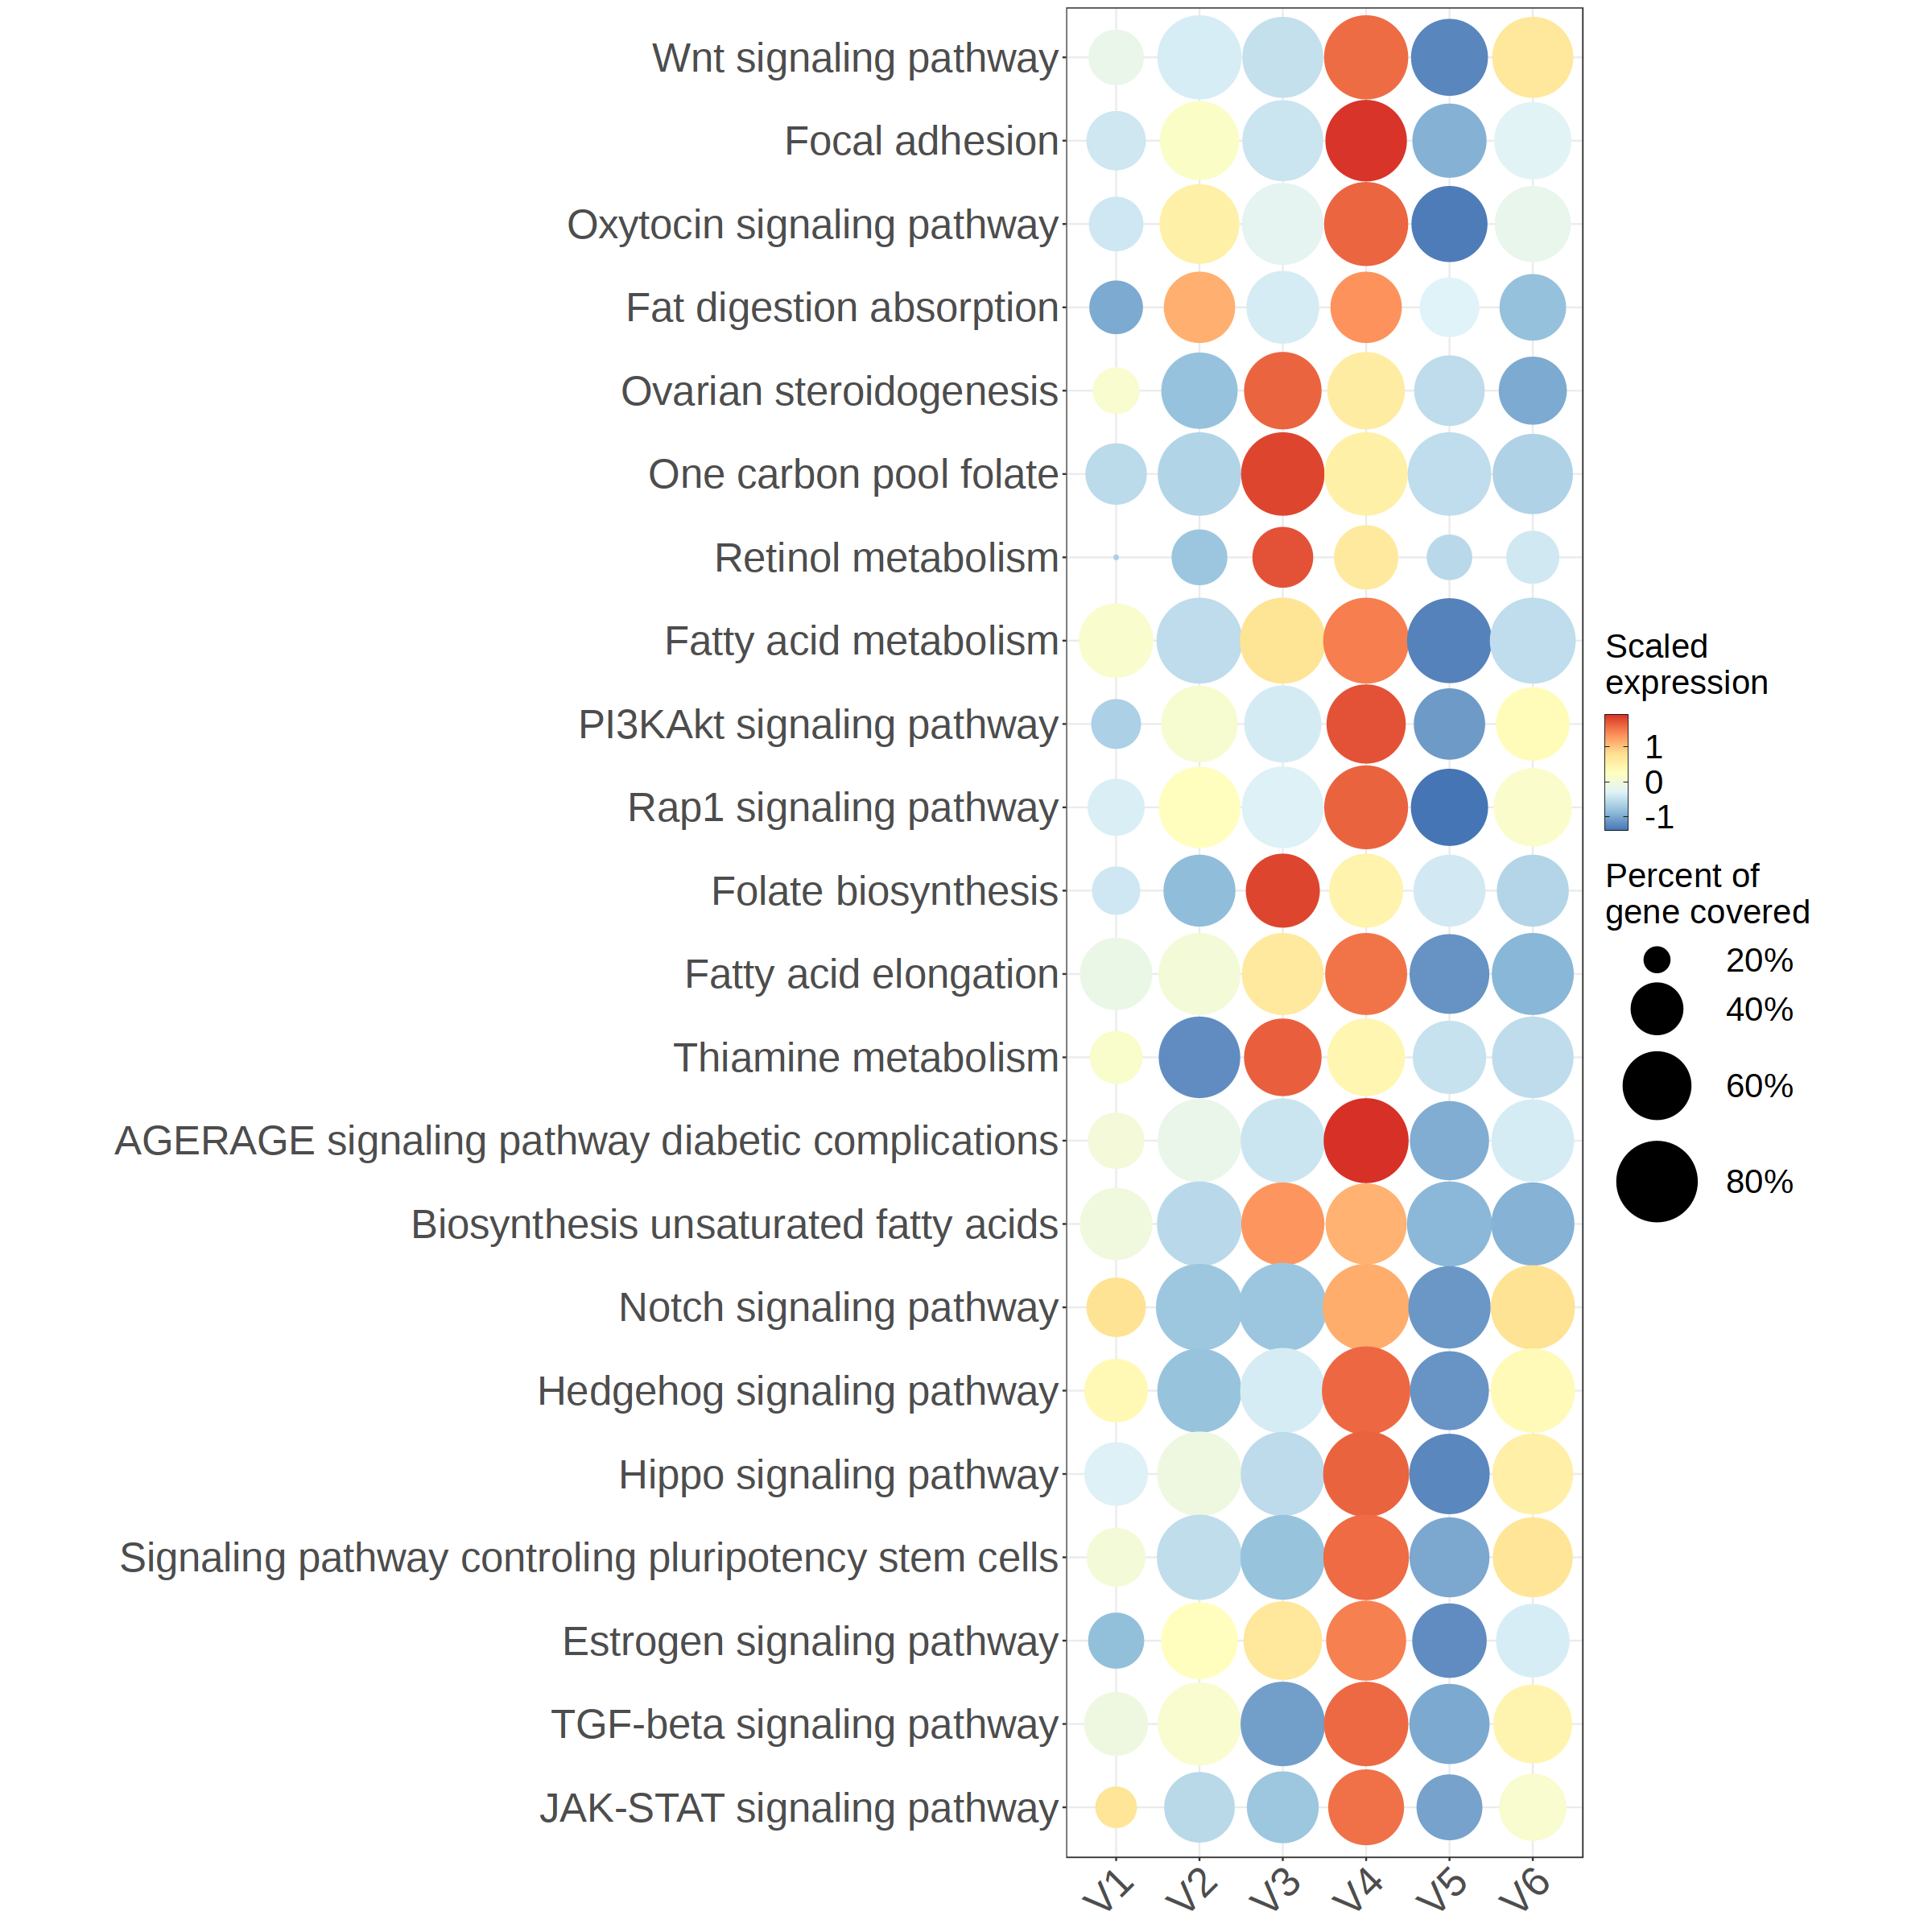

In [32]:
# for every cluster-gene combination, calculate the average expression across
# all cells and then transform the data into a data frame
expression_levels_per_cluster <- scale(path_df) %>%
  t() %>%
  as.data.frame() %>%
  mutate(cluster = rownames(.)) %>%
  dplyr::select(cluster, everything()) %>%
  pivot_longer(
    cols = c(2:ncol(.)),
    names_to = 'gene'
  ) %>%
  dplyr::rename(expression = value) %>%
  mutate(id_to_merge = paste0(cluster, '_', gene))

# for every cluster-gene combination, calculate the percentage of cells in the
# respective group that has at least 1 transcript (this means we consider it
# as expressing the gene) and then transform the data into a data frame
percentage_of_cells_expressing_gene <- percent_df %>%
  t() %>%
  as.data.frame() %>%
  mutate(cluster = rownames(.)) %>%
  dplyr::select(cluster, everything()) %>%
  pivot_longer(
    cols = c(2:ncol(.)),
    names_to = 'gene'
  ) %>%
  dplyr::rename(cell_count = value) %>%
  left_join(
    .,
    length_path,
    by = 'cluster') %>%
  mutate(
    id_to_merge = paste0(cluster, '_', gene),
    percent_cells = cell_count / n
  )

# merge the two data frames created before and plot the data
p <- left_join(
    expression_levels_per_cluster,
    percentage_of_cells_expressing_gene %>%
    dplyr::select(id_to_merge, percent_cells),
    by = 'id_to_merge'
  ) %>%
  mutate(cluster = factor(cluster, levels = rev(cluster_ids))) %>%
  ggplot(aes(gene, cluster)) +
  geom_point(aes(color = expression, size = percent_cells)) +
  scale_color_distiller(
    palette = 'RdYlBu',
    direction = -1,
    name = 'Scaled\nexpression',
    guide = guide_colorbar(frame.colour = "black", ticks.colour = "black")
  ) +
  scale_size(name = 'Percent of\ngene covered',
             labels = scales::percent,
             limits = c(min(percentage_of_cells_expressing_gene$percent_cells), max(percentage_of_cells_expressing_gene$percent_cells)),
             range = c(1, 30)
            ) +
  scale_y_discrete(labels = c('JAK-STAT signaling pathway', 'TGF-beta signaling pathway', 'Estrogen signaling pathway', 'Signaling pathway controling pluripotency stem cells',
               'Hippo signaling pathway', 'Hedgehog signaling pathway', 'Notch signaling pathway', 'Biosynthesis unsaturated fatty acids',
               'AGERAGE signaling pathway diabetic complications', 'Thiamine metabolism', 'Fatty acid elongation', 'Folate biosynthesis',
               'Rap1 signaling pathway', 'PI3KAkt signaling pathway', 'Fatty acid metabolism', 'Retinol metabolism', 'One carbon pool folate',
               'Ovarian steroidogenesis', 'Fat digestion absorption', 'Oxytocin signaling pathway', 'Focal adhesion', 'Wnt signaling pathway')
  ) +
  labs(y = 'Cluster', color = 'Expression') +
  coord_fixed() +
  theme_bw() +
  theme(
    axis.title.x = element_blank(),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 30),
    legend.text = element_text(size = 25),
    legend.title = element_text(size = 25),
    axis.title.y = element_blank(),
    axis.text.y = element_text(size = 30)
  )

p

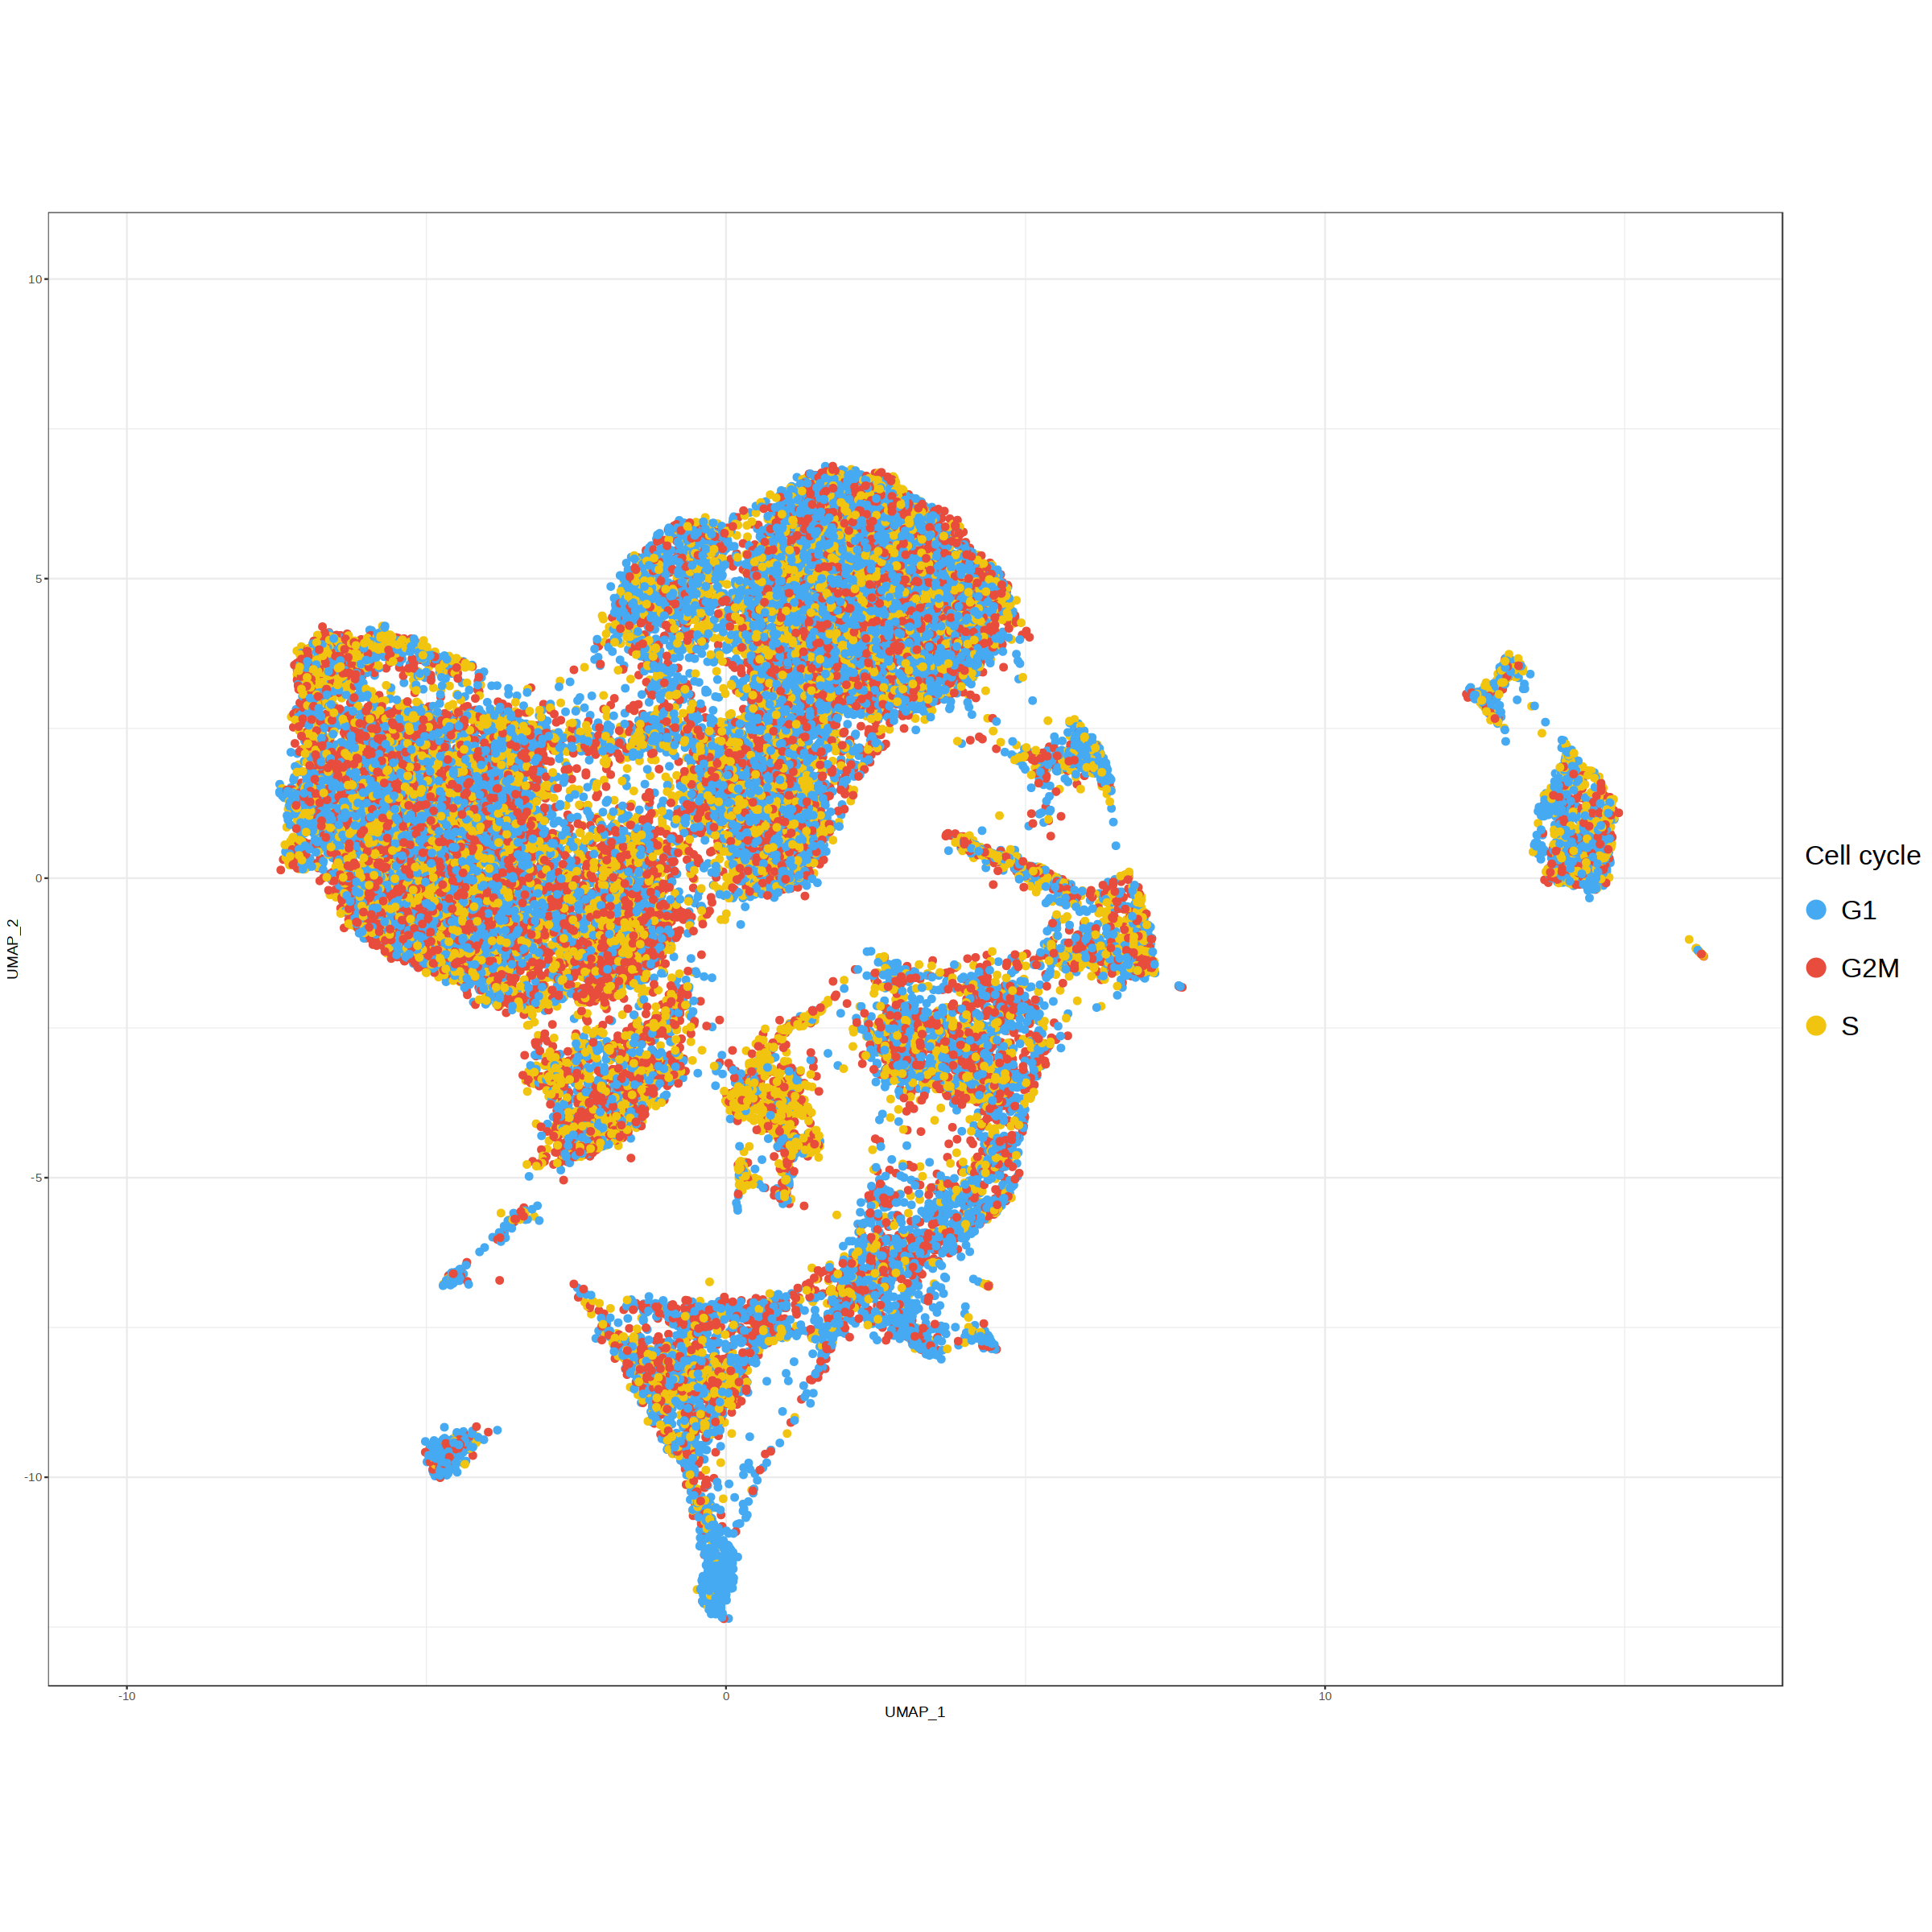

In [33]:
UMAP_centers_cell_type <- tibble(
    UMAP_1 = as.data.frame(embryos.integrated@reductions$umap@cell.embeddings)$UMAP_1,
    UMAP_2 = as.data.frame(embryos.integrated@reductions$umap@cell.embeddings)$UMAP_2,
    Phase = embryos.integrated@meta.data$Phase
  ) %>%
  group_by(Phase) %>%
  summarize(x = median(UMAP_1), y = median(UMAP_2))

p <- bind_cols(embryos.integrated@meta.data, as.data.frame(embryos.integrated@reductions$umap@cell.embeddings)) %>%
  ggplot(aes(UMAP_1, UMAP_2, color = Phase)) +
  geom_point(size = 2) +
  theme_bw() +
  expand_limits(x = c(-10,10.5), y = c(-10,10)) +
  scale_color_manual(values = custom_colors$cell_cycle) +
  labs(color = 'Cell cycle') +
  guides(colour = guide_legend(override.aes = list(size = 6))) +
  theme(legend.position = 'right',
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 20),
        legend.key.height = unit(3,"line")
       ) +
  coord_fixed()

p

In [34]:
ggsave(
  '/home/adufour/work/notebook/plots/ALL_UMAP/umap_cell_cycle.svg',
  plot,
  height = 18,
  width = 20
)

In [ ]:
UMAP_centers_cell_type <- tibble(
    UMAP_1 = as.data.frame(embryos.integrated@reductions$umap@cell.embeddings)$UMAP_1,
    UMAP_2 = as.data.frame(embryos.integrated@reductions$umap@cell.embeddings)$UMAP_2,
    sexe = embryos.integrated@meta.data$sexe
  ) %>%
  group_by(sexe) %>%
  summarize(x = median(UMAP_1), y = median(UMAP_2))

plot <- bind_cols(embryos.integrated@meta.data, as.data.frame(embryos.integrated@reductions$umap@cell.embeddings)) %>%
  ggplot(aes(UMAP_1, UMAP_2, color = sexe)) +
  geom_point(size = 2) +
  theme_bw() +
  expand_limits(x = c(-10,10.5), y = c(-10,10)) +
  scale_color_manual(values = custom_colors$discrete) +
  labs(color = 'Cell sex') +
  guides(colour = guide_legend(override.aes = list(size = 6))) +
  theme(legend.position = 'right',
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 20),
        legend.key.height = unit(3,"line")
       ) +
  coord_fixed()

plot

In [ ]:
ggsave(
  '/home/adufour/work/notebook/plots/ALL_UMAP/umap_cell_sexe.svg',
  plot,
  height = 18,
  width = 20
)